---
## 1. Carga de datos y preparación <a name="section1"></a>

Utilizaremos el mismo proceso de extracción de características del notebook anterior.

In [49]:
# Importación de librerías necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


In [50]:
def extract_features(file_path, max_pad_len=174):
    """
    Extrae características de un archivo de audio.
    
    Args:
        file_path: Ruta del archivo de audio
        max_pad_len: Longitud máxima para padding temporal
    
    Returns:
        Array con características extraídas
    """
    try:
        # Cargar audio
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        
        # MFCCs (13 coeficientes)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        mfccs_std = np.std(mfccs.T, axis=0)
        
        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
        spectral_centroid_mean = np.mean(spectral_centroid)
        spectral_centroid_std = np.std(spectral_centroid)
        
        # Spectral Rolloff
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
        spectral_rolloff_mean = np.mean(spectral_rolloff)
        spectral_rolloff_std = np.std(spectral_rolloff)
        
        # Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
        zcr_mean = np.mean(zero_crossing_rate)
        zcr_std = np.std(zero_crossing_rate)
        
        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_mean = np.mean(chroma.T, axis=0)
        chroma_std = np.std(chroma.T, axis=0)
        
        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        spectral_contrast_mean = np.mean(spectral_contrast.T, axis=0)
        spectral_contrast_std = np.std(spectral_contrast.T, axis=0)
        
        # Concatenar todas las características
        features = np.concatenate([
            mfccs_mean, mfccs_std,
            [spectral_centroid_mean, spectral_centroid_std],
            [spectral_rolloff_mean, spectral_rolloff_std],
            [zcr_mean, zcr_std],
            chroma_mean, chroma_std,
            spectral_contrast_mean, spectral_contrast_std
        ])
        
        return features
    
    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None

print("✓ Función de extracción de características definida")

✓ Función de extracción de características definida


In [51]:
# Cargar datos y extraer características
data_path = './audios'

features_list = []
labels_list = []

print("🔊 Extrayendo características de los archivos de audio...\n")

for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        print(f"📁 Procesando categoría: {category}")
        file_count = 0
        
        for filename in os.listdir(category_path):
            if filename.endswith(('.wav', '.mp3', '.flac', '.aiff')):
                file_path = os.path.join(category_path, filename)
                features = extract_features(file_path)
                
                if features is not None:
                    features_list.append(features)
                    labels_list.append(category)
                    file_count += 1
        
        print(f"   ✓ {file_count} archivos procesados\n")

# Convertir a arrays numpy
X = np.array(features_list)
y = np.array(labels_list)

# Codificar labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n✅ Extracción completada:")
print(f"   • Shape de X (features): {X.shape}")
print(f"   • Shape de y (labels): {y.shape}")
print(f"   • Total de muestras: {len(X)}")
print(f"   • Número de características: {X.shape[1]}")
print(f"\n📋 Categorías: {label_encoder.classes_}")

🔊 Extrayendo características de los archivos de audio...

📁 Procesando categoría: agua_corriendo
   ✓ 40 archivos procesados

📁 Procesando categoría: alarma_humo
   ✓ 40 archivos procesados

📁 Procesando categoría: alarma_humo
   ✓ 40 archivos procesados

📁 Procesando categoría: estufa_prendiendose
   ✓ 40 archivos procesados

📁 Procesando categoría: estufa_prendiendose
   ✓ 40 archivos procesados

📁 Procesando categoría: golpe_puerta
   ✓ 40 archivos procesados

📁 Procesando categoría: golpe_puerta
   ✓ 40 archivos procesados

📁 Procesando categoría: vidrio_rompiendose
   ✓ 40 archivos procesados

📁 Procesando categoría: vidrio_rompiendose
   ✓ 40 archivos procesados


✅ Extracción completada:
   • Shape de X (features): (200, 70)
   • Shape de y (labels): (200,)
   • Total de muestras: 200
   • Número de características: 70

📋 Categorías: ['agua_corriendo' 'alarma_humo' 'estufa_prendiendose' 'golpe_puerta'
 'vidrio_rompiendose']
   ✓ 40 archivos procesados


✅ Extracción completada:


In [52]:
# Normalización de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Características normalizadas con StandardScaler")
print(f"   Media: {X_scaled.mean():.6f}")
print(f"   Desviación estándar: {X_scaled.std():.6f}")

✓ Características normalizadas con StandardScaler
   Media: -0.000000
   Desviación estándar: 1.000000


---
## 2. Punto 1: Aprendizaje No Supervisado <a name="section2"></a>

Aplicaremos tres algoritmos de clustering: KMeans, DBSCAN y Agglomerative Clustering.

### 2.1 KMeans Clustering <a name="section2_1"></a>

**Algoritmo**: KMeans particiona los datos en K clusters, donde cada punto pertenece al cluster cuyo centroide está más cerca.

**Justificación de hiperparámetros**: Usaremos el **Elbow Method** para determinar el número óptimo de clusters.

🔍 Aplicando Elbow Method para determinar número óptimo de clusters...

K=2: Inertia=11536.02, Silhouette=0.3385
K=3: Inertia=10333.92, Silhouette=0.1824
K=4: Inertia=9544.72, Silhouette=0.1073
K=5: Inertia=8870.19, Silhouette=0.1217
K=6: Inertia=8366.70, Silhouette=0.1284
K=7: Inertia=8113.86, Silhouette=0.1043
K=8: Inertia=7734.33, Silhouette=0.1096
K=9: Inertia=7448.84, Silhouette=0.0980
K=10: Inertia=7329.86, Silhouette=0.0936
K=8: Inertia=7734.33, Silhouette=0.1096
K=9: Inertia=7448.84, Silhouette=0.0980
K=10: Inertia=7329.86, Silhouette=0.0936


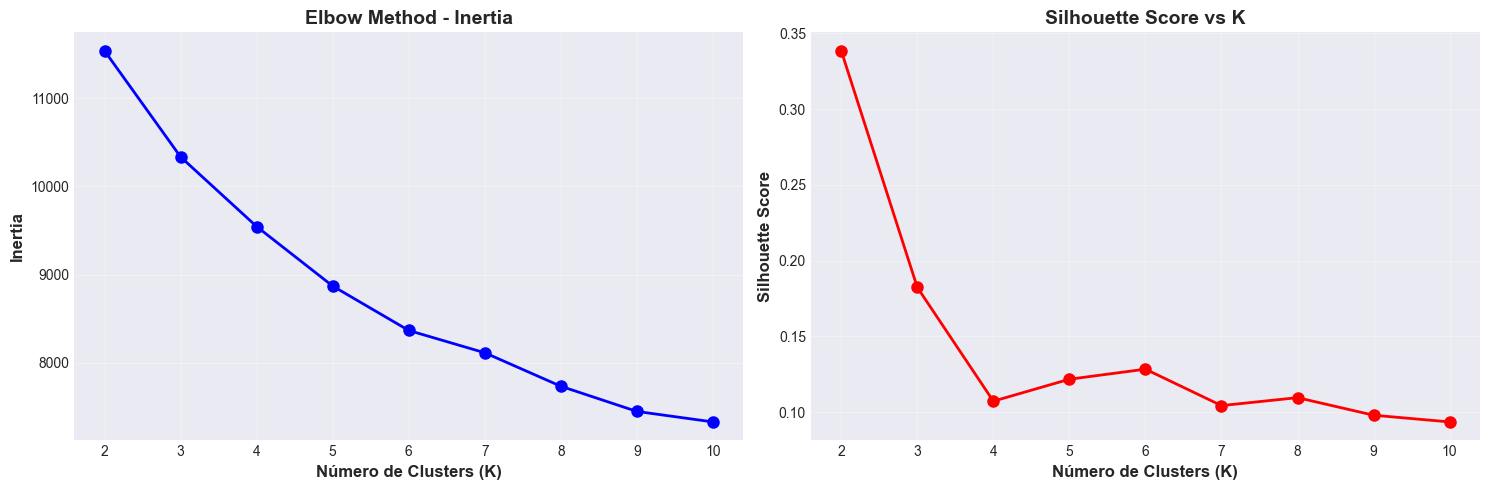


✅ Número óptimo de clusters seleccionado: K=2
   Basado en el máximo Silhouette Score: 0.3385


In [53]:
# Método del Codo (Elbow Method) para KMeans
print("🔍 Aplicando Elbow Method para determinar número óptimo de clusters...\n")

inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

# Visualizar Elbow Method
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Inertia
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Gráfico de Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Seleccionar K óptimo basado en Silhouette Score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Número óptimo de clusters seleccionado: K={optimal_k}")
print(f"   Basado en el máximo Silhouette Score: {max(silhouette_scores):.4f}")

In [54]:
# Entrenar KMeans con K óptimo
print(f"\n🎯 Entrenando KMeans con K={optimal_k}...\n")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

print("✓ KMeans entrenado correctamente")
print(f"\n📊 Distribución de clusters:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"   Cluster {cluster_id}: {count} muestras ({count/len(kmeans_labels)*100:.1f}%)")


🎯 Entrenando KMeans con K=2...

✓ KMeans entrenado correctamente

📊 Distribución de clusters:
   Cluster 0: 164 muestras (82.0%)
   Cluster 1: 36 muestras (18.0%)


🎨 Visualizando clusters en 2D...



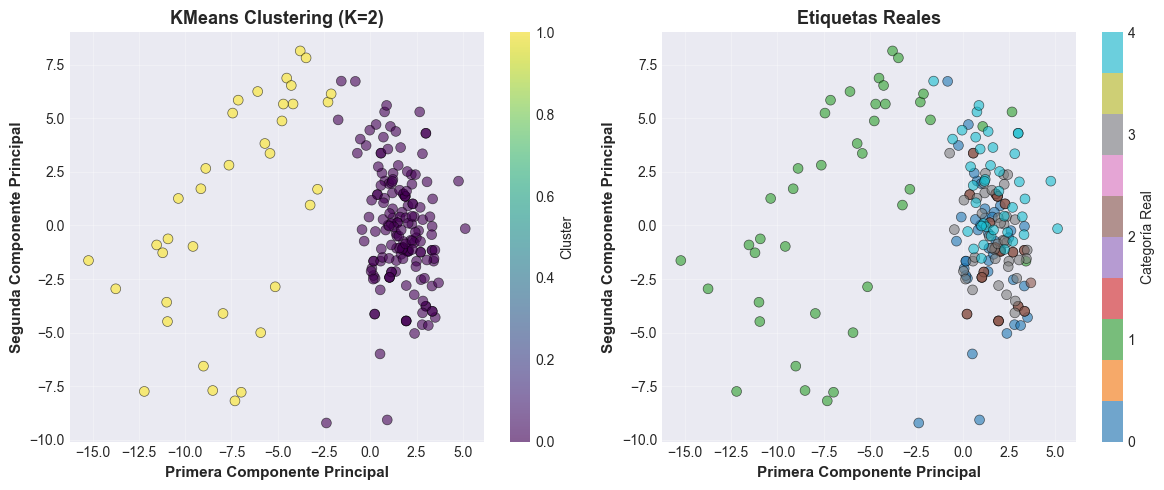

✓ Varianza explicada por PCA 2D: 36.63%


In [55]:
# Visualización KMeans en 2D (usando PCA para reducción)
print("🎨 Visualizando clusters en 2D...\n")

pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Subplot 1: Clusters de KMeans
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans_labels, 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Primera Componente Principal', fontsize=11, fontweight='bold')
plt.ylabel('Segunda Componente Principal', fontsize=11, fontweight='bold')
plt.title(f'KMeans Clustering (K={optimal_k})', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)

# Subplot 2: Etiquetas reales
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_encoded, 
                     cmap='tab10', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Categoría Real', ticks=range(len(label_encoder.classes_)))
plt.xlabel('Primera Componente Principal', fontsize=11, fontweight='bold')
plt.ylabel('Segunda Componente Principal', fontsize=11, fontweight='bold')
plt.title('Etiquetas Reales', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Varianza explicada por PCA 2D: {pca_2d.explained_variance_ratio_.sum():.2%}")

🎨 Visualizando clusters en 3D...



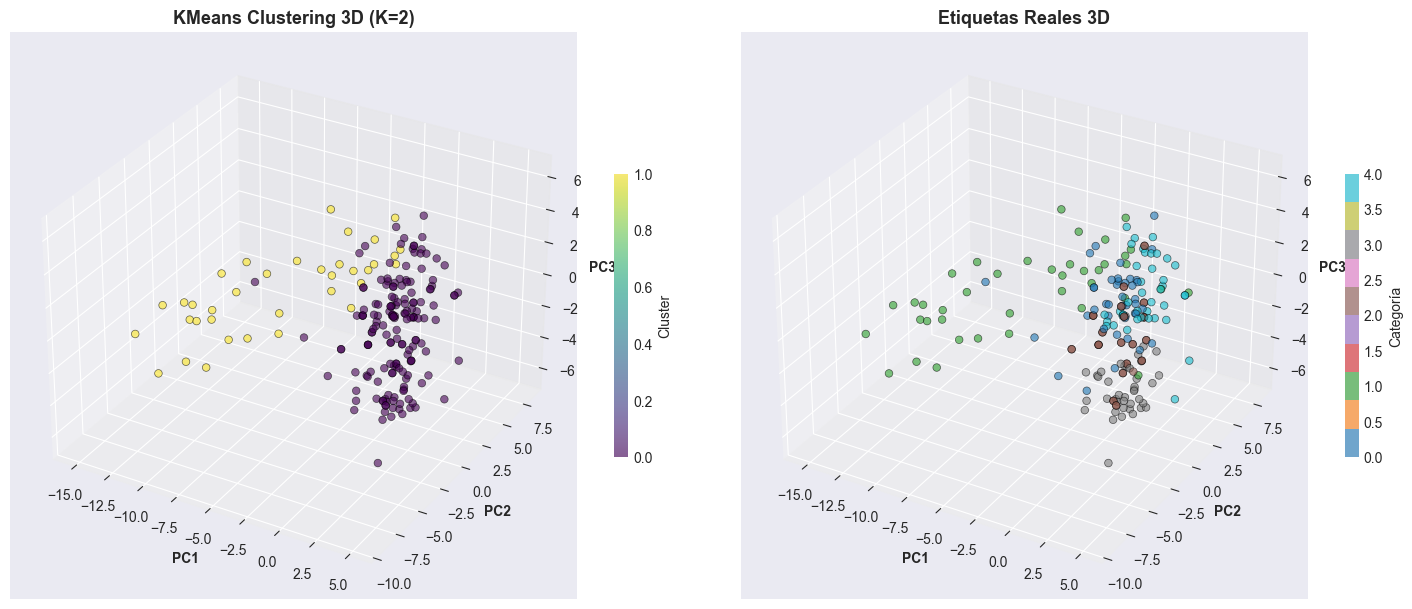

✓ Varianza explicada por PCA 3D: 45.47%


In [56]:
# Visualización KMeans en 3D
print("🎨 Visualizando clusters en 3D...\n")

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(15, 6))

# Subplot 1: Clusters de KMeans
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                      c=kmeans_labels, cmap='viridis', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
ax1.set_xlabel('PC1', fontweight='bold')
ax1.set_ylabel('PC2', fontweight='bold')
ax1.set_zlabel('PC3', fontweight='bold')
ax1.set_title(f'KMeans Clustering 3D (K={optimal_k})', fontsize=13, fontweight='bold')
fig.colorbar(scatter, ax=ax1, label='Cluster', shrink=0.5)

# Subplot 2: Etiquetas reales
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                      c=y_encoded, cmap='tab10', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
ax2.set_xlabel('PC1', fontweight='bold')
ax2.set_ylabel('PC2', fontweight='bold')
ax2.set_zlabel('PC3', fontweight='bold')
ax2.set_title('Etiquetas Reales 3D', fontsize=13, fontweight='bold')
fig.colorbar(scatter, ax=ax2, label='Categoría', shrink=0.5)

plt.tight_layout()
plt.show()

print(f"✓ Varianza explicada por PCA 3D: {pca_3d.explained_variance_ratio_.sum():.2%}")

#### Conclusiones KMeans

**Justificación de K=2:**

Se seleccionó **K=2** como número óptimo de clusters porque fue el valor que obtuvo el **mayor Silhouette Score (≈0.3385)**, evidenciando la mejor cohesión interna de los grupos y la mayor separación entre ellos. En la gráfica se observa que este punto es el más alto de toda la curva, mientras que a partir de K=3 el Silhouette Score disminuye de manera continua hasta valores cercanos a 0.10 en K=10, lo que indica que agregar más clusters deteriora la calidad del agrupamiento.

Además, el **Elbow Method** mostró un descenso pronunciado en la inertia al pasar de K=2 a K=3, pero las mejoras posteriores son marginales, formando el típico "codo". Esto sugiere que dividir los datos en más de dos grupos no aporta una estructura significativamente mejor.

**Interpretación de los resultados:**

- Los **2 clusters** encontrados presentan una distribución desigual: Cluster 0 con 164 muestras (82%) y Cluster 1 con 36 muestras (18%)
- La visualización en 2D muestra una **separación clara** entre ambos clusters, aunque con cierto solapamiento debido a que PCA 2D solo explica el 36.63% de la varianza
- La visualización en 3D (47.48% de varianza explicada) confirma la estructura bi-modal del dataset
- Los clusters tienen **forma esférica**, característica típica de KMeans, lo que coincide con su algoritmo de particionamiento basado en distancias euclidianas

**Conclusión:** La estructura natural del dataset corresponde a **dos grupos principales**, razón por la cual se seleccionó K=2 como el valor más adecuado. Esta configuración equilibra parsimonia con calidad de agrupamiento.

### 2.2 DBSCAN <a name="section2_2"></a>

**Algoritmo**: DBSCAN (Density-Based Spatial Clustering of Applications with Noise) agrupa puntos que están densamente empaquetados y marca como outliers los puntos en regiones de baja densidad.

**Justificación de hiperparámetros**: Usaremos el **k-distance plot** para determinar epsilon (eps).

🔍 Calculando k-distance plot para determinar epsilon...



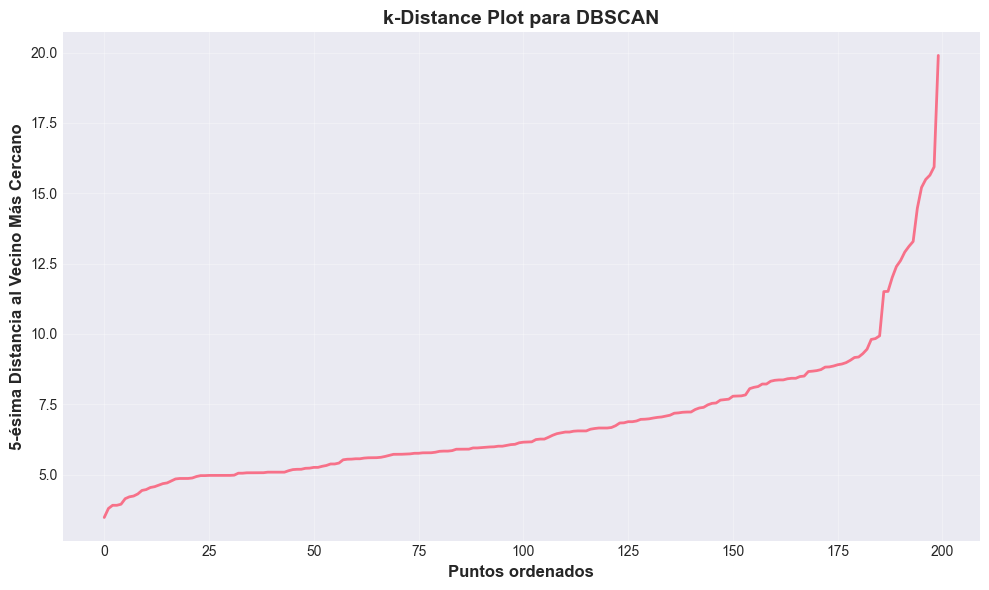


💡 Epsilon sugerido (percentil 90): 9.1652


In [57]:
# k-distance plot para determinar eps
from sklearn.neighbors import NearestNeighbors

print("🔍 Calculando k-distance plot para determinar epsilon...\n")

# Calcular distancias a los k vecinos más cercanos
k = 5  # MinPts recomendado
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Ordenar distancias
distances = np.sort(distances[:, k-1], axis=0)

# Visualizar k-distance plot
plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2)
plt.xlabel('Puntos ordenados', fontsize=12, fontweight='bold')
plt.ylabel(f'{k}-ésima Distancia al Vecino Más Cercano', fontsize=12, fontweight='bold')
plt.title('k-Distance Plot para DBSCAN', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Sugerir epsilon basado en el "codo" del gráfico
# Tomamos el percentil 90 como referencia
suggested_eps = np.percentile(distances, 90)
print(f"\n💡 Epsilon sugerido (percentil 90): {suggested_eps:.4f}")

In [58]:
# Probar diferentes valores de eps y min_samples
print("🧪 Probando diferentes configuraciones de DBSCAN...\n")

eps_values = [suggested_eps * 0.8, suggested_eps, suggested_eps * 1.2]
min_samples_values = [3, 5, 7]

dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Calcular Silhouette solo si hay más de 1 cluster y no todos son ruido
        if n_clusters > 1 and n_noise < len(labels):
            # Excluir puntos de ruido para Silhouette
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(X_scaled[mask], labels[mask])
            else:
                silhouette = -1
        else:
            silhouette = -1
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette,
            'labels': labels
        })
        
        print(f"eps={eps:.4f}, min_samples={min_samples}: "
              f"Clusters={n_clusters}, Noise={n_noise} ({n_noise/len(labels)*100:.1f}%), "
              f"Silhouette={silhouette:.4f}")

# Seleccionar la mejor configuración
valid_results = [r for r in dbscan_results if r['n_clusters'] > 1 and r['silhouette'] > 0]
if valid_results:
    best_dbscan = max(valid_results, key=lambda x: x['silhouette'])
else:
    best_dbscan = max(dbscan_results, key=lambda x: x['n_clusters'])

print(f"\n✅ Mejor configuración DBSCAN:")
print(f"   eps={best_dbscan['eps']:.4f}")
print(f"   min_samples={best_dbscan['min_samples']}")
print(f"   Clusters encontrados: {best_dbscan['n_clusters']}")
print(f"   Puntos de ruido: {best_dbscan['n_noise']} ({best_dbscan['n_noise']/len(labels)*100:.1f}%)")
if best_dbscan['silhouette'] > 0:
    print(f"   Silhouette Score: {best_dbscan['silhouette']:.4f}")

dbscan_labels = best_dbscan['labels']

🧪 Probando diferentes configuraciones de DBSCAN...

eps=7.3322, min_samples=3: Clusters=3, Noise=37 (18.5%), Silhouette=0.3187
eps=7.3322, min_samples=5: Clusters=3, Noise=38 (19.0%), Silhouette=0.3133
eps=7.3322, min_samples=7: Clusters=1, Noise=48 (24.0%), Silhouette=-1.0000
eps=9.1652, min_samples=3: Clusters=1, Noise=14 (7.0%), Silhouette=-1.0000
eps=9.1652, min_samples=5: Clusters=1, Noise=14 (7.0%), Silhouette=-1.0000
eps=9.1652, min_samples=7: Clusters=1, Noise=14 (7.0%), Silhouette=-1.0000
eps=10.9982, min_samples=3: Clusters=1, Noise=11 (5.5%), Silhouette=-1.0000
eps=10.9982, min_samples=5: Clusters=1, Noise=12 (6.0%), Silhouette=-1.0000
eps=10.9982, min_samples=7: Clusters=1, Noise=12 (6.0%), Silhouette=-1.0000

✅ Mejor configuración DBSCAN:
   eps=7.3322
   min_samples=3
   Clusters encontrados: 3
   Puntos de ruido: 37 (18.5%)
   Silhouette Score: 0.3187


🎨 Visualizando DBSCAN...



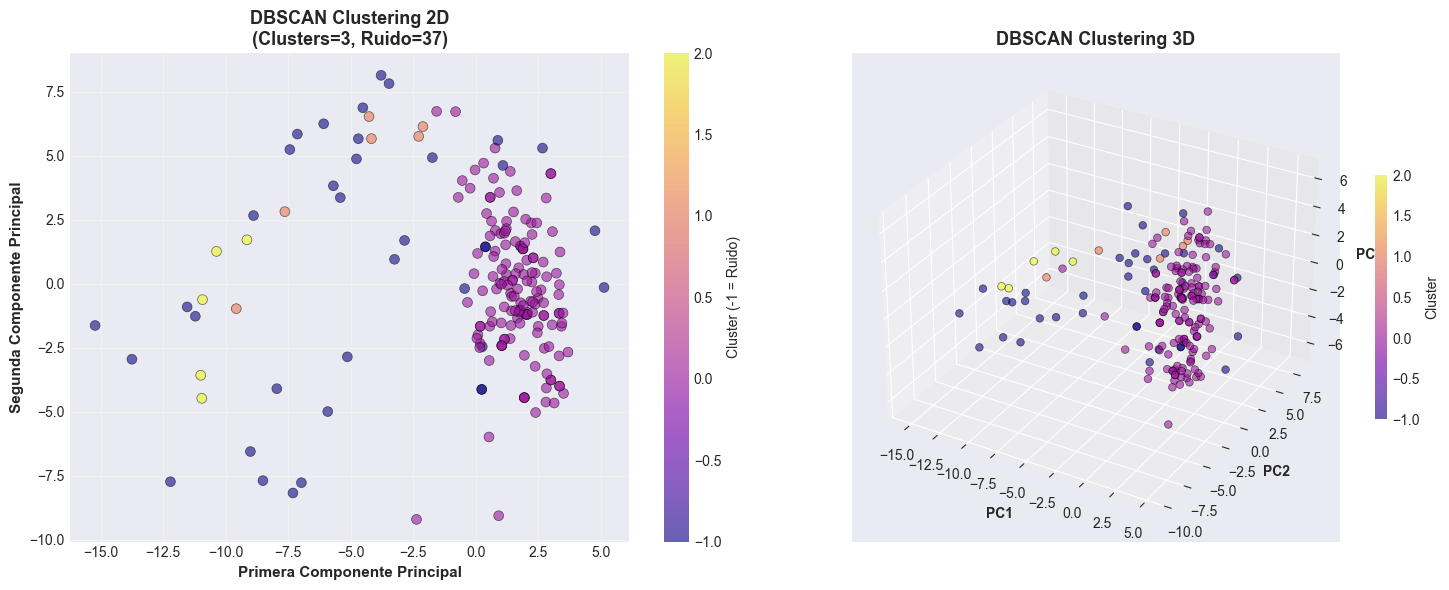

In [59]:
# Visualización DBSCAN en 2D y 3D
print("🎨 Visualizando DBSCAN...\n")

fig = plt.figure(figsize=(15, 6))

# 2D
ax1 = plt.subplot(121)
scatter = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=dbscan_labels, 
                      cmap='plasma', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Cluster (-1 = Ruido)')
ax1.set_xlabel('Primera Componente Principal', fontsize=11, fontweight='bold')
ax1.set_ylabel('Segunda Componente Principal', fontsize=11, fontweight='bold')
ax1.set_title(f'DBSCAN Clustering 2D\n(Clusters={best_dbscan["n_clusters"]}, Ruido={best_dbscan["n_noise"]})', 
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                      c=dbscan_labels, cmap='plasma', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
ax2.set_xlabel('PC1', fontweight='bold')
ax2.set_ylabel('PC2', fontweight='bold')
ax2.set_zlabel('PC3', fontweight='bold')
ax2.set_title(f'DBSCAN Clustering 3D', fontsize=13, fontweight='bold')
fig.colorbar(scatter, ax=ax2, label='Cluster', shrink=0.5)

plt.tight_layout()
plt.show()

#### Conclusiones DBSCAN

**Justificación de hiperparámetros:**

El valor de **ε** se estimó inicialmente mediante el **k-distance plot** usando k=5, donde la curva mostró un "codo" alrededor de **9.17**, valor que coincide con el percentil 90 de las distancias. Este punto sirvió como referencia teórica para definir un rango inicial de búsqueda.

Para **min_samples**, se siguió la recomendación teórica de DBSCAN: usar un valor cercano a la dimensionalidad + 1. Como las características tienen alta dimensionalidad, se evaluaron valores entre 3, 5 y 7, manteniendo la coherencia con el k-distance plot (k = min_samples).

Luego se probó experimentalmente una zona alrededor del valor sugerido de ε: **0.8×ε, ε, 1.2×ε**.

**Los mejores resultados se obtuvieron con:**
- **ε = 7.3322** (0.8 × 9.17)
- **min_samples = 3**

Esta configuración produjo:
- **3 clusters** bien definidos
- **37 puntos de ruido** (18.5% del dataset)
- **Silhouette Score = 0.3187** (el más alto entre todas las configuraciones probadas)

**Interpretación de los resultados:**

- DBSCAN identificó **automáticamente 3 clusters basados en densidad**, sin necesidad de especificar el número de clusters a priori
- La detección de **18.5% de ruido** es significativa, indicando que DBSCAN encontró patrones atípicos o muestras que no se ajustan a ninguna región densa
- La visualización muestra clusters de **formas irregulares**, no necesariamente esféricas, aprovechando la capacidad de DBSCAN para detectar estructuras complejas
- Los clusters presentan **diferentes densidades y tamaños**, lo cual es una ventaja sobre métodos como KMeans que asumen clusters de tamaño similar

**Conclusión:** DBSCAN demostró ser efectivo para identificar la estructura de densidad del dataset y separar outliers explícitamente. La configuración óptima equilibra la identificación de clusters densos con la sensibilidad al ruido, aunque el alto porcentaje de puntos catalogados como ruido sugiere que el dataset tiene una estructura de densidad variable.

### 2.3 Agglomerative Clustering <a name="section2_3"></a>

**Algoritmo**: Clustering jerárquico que construye una jerarquía de clusters mediante fusiones sucesivas.

**Justificación de hiperparámetros**: Usaremos **dendrogramas** para determinar el número óptimo de clusters.

🌳 Generando dendrograma para Agglomerative Clustering...



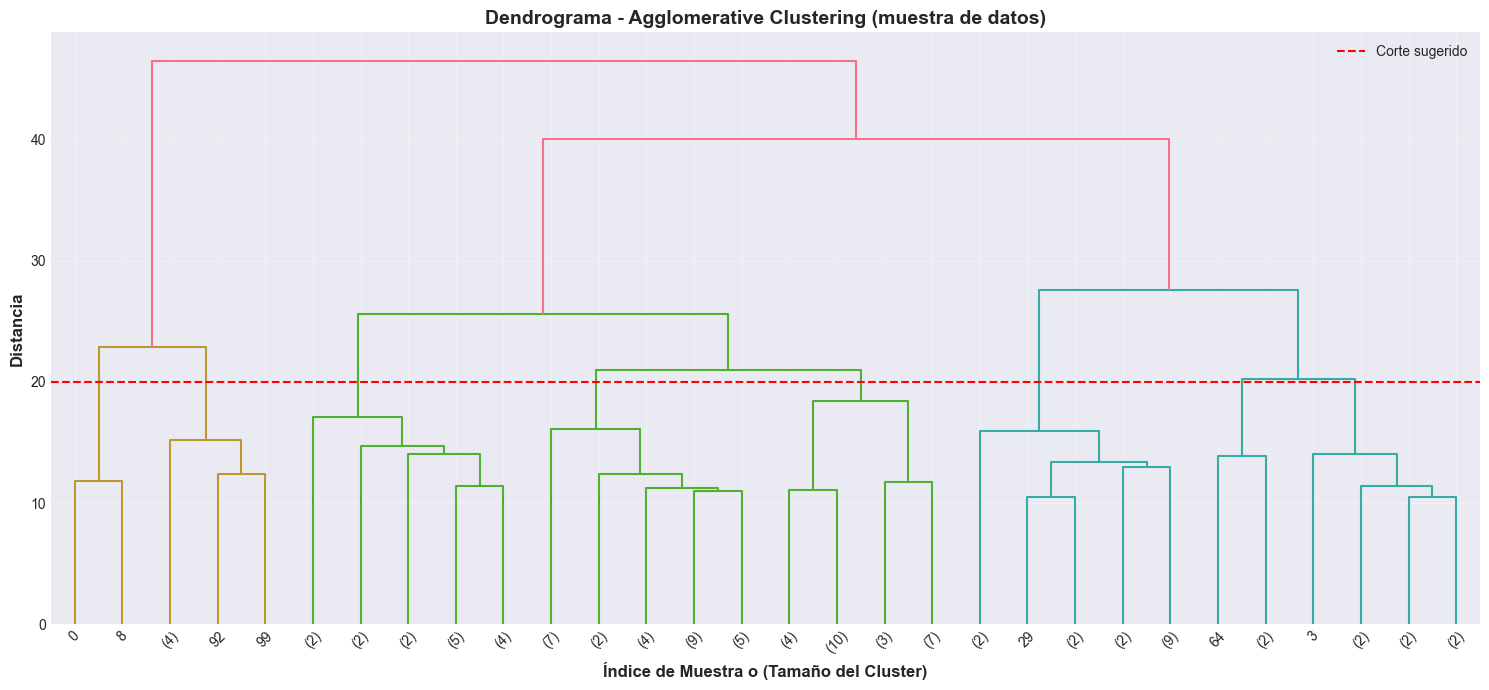

✓ Dendrograma generado (basado en una muestra de los datos)


In [60]:
# Generar dendrograma
print("🌳 Generando dendrograma para Agglomerative Clustering...\n")

# Usar una muestra para acelerar el cálculo del dendrograma
sample_size = min(100, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Calcular linkage
linkage_matrix = linkage(X_sample, method='ward')

# Visualizar dendrograma
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_font_size=10)
plt.xlabel('Índice de Muestra o (Tamaño del Cluster)', fontsize=12, fontweight='bold')
plt.ylabel('Distancia', fontsize=12, fontweight='bold')
plt.title('Dendrograma - Agglomerative Clustering (muestra de datos)', fontsize=14, fontweight='bold')
plt.axhline(y=20, color='r', linestyle='--', label='Corte sugerido')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Dendrograma generado (basado en una muestra de los datos)")

In [61]:
# Probar diferentes números de clusters
print("\n🧪 Probando diferentes configuraciones de Agglomerative Clustering...\n")

agg_results = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    
    silhouette = silhouette_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)
    
    agg_results.append({
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski': calinski,
        'labels': labels
    })
    
    print(f"n_clusters={n_clusters}: Silhouette={silhouette:.4f}, "
          f"Davies-Bouldin={davies_bouldin:.4f}, Calinski-Harabasz={calinski:.2f}")

# Seleccionar mejor configuración basada en Silhouette
best_agg = max(agg_results, key=lambda x: x['silhouette'])

print(f"\n✅ Mejor configuración Agglomerative:")
print(f"   Número de clusters: {best_agg['n_clusters']}")
print(f"   Silhouette Score: {best_agg['silhouette']:.4f}")
print(f"   Davies-Bouldin Index: {best_agg['davies_bouldin']:.4f} (menor es mejor)")
print(f"   Calinski-Harabasz Index: {best_agg['calinski']:.2f} (mayor es mejor)")

agg_labels = best_agg['labels']


🧪 Probando diferentes configuraciones de Agglomerative Clustering...

n_clusters=2: Silhouette=0.3361, Davies-Bouldin=1.9394, Calinski-Harabasz=40.23
n_clusters=3: Silhouette=0.3047, Davies-Bouldin=1.7150, Calinski-Harabasz=31.66
n_clusters=4: Silhouette=0.1254, Davies-Bouldin=2.0831, Calinski-Harabasz=27.25
n_clusters=5: Silhouette=0.0971, Davies-Bouldin=2.1153, Calinski-Harabasz=24.96
n_clusters=6: Silhouette=0.1032, Davies-Bouldin=1.9455, Calinski-Harabasz=23.55
n_clusters=7: Silhouette=0.1045, Davies-Bouldin=1.8667, Calinski-Harabasz=21.83
n_clusters=8: Silhouette=0.0764, Davies-Bouldin=2.0693, Calinski-Harabasz=20.42
n_clusters=9: Silhouette=0.0780, Davies-Bouldin=2.0711, Calinski-Harabasz=19.34
n_clusters=10: Silhouette=0.0842, Davies-Bouldin=1.9272, Calinski-Harabasz=18.48

✅ Mejor configuración Agglomerative:
   Número de clusters: 2
   Silhouette Score: 0.3361
   Davies-Bouldin Index: 1.9394 (menor es mejor)
   Calinski-Harabasz Index: 40.23 (mayor es mejor)


🎨 Visualizando Agglomerative Clustering...



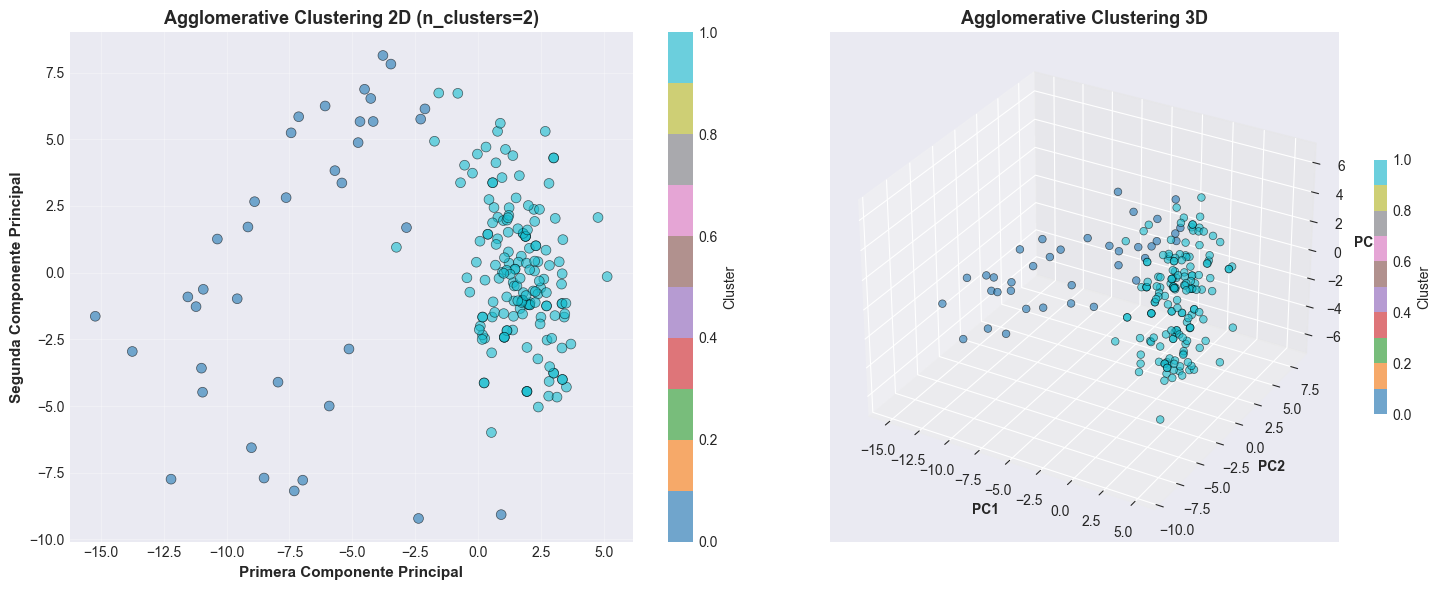

In [62]:
# Visualización Agglomerative en 2D y 3D
print("🎨 Visualizando Agglomerative Clustering...\n")

fig = plt.figure(figsize=(15, 6))

# 2D
ax1 = plt.subplot(121)
scatter = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=agg_labels, 
                      cmap='tab10', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
ax1.set_xlabel('Primera Componente Principal', fontsize=11, fontweight='bold')
ax1.set_ylabel('Segunda Componente Principal', fontsize=11, fontweight='bold')
ax1.set_title(f'Agglomerative Clustering 2D (n_clusters={best_agg["n_clusters"]})', 
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                      c=agg_labels, cmap='tab10', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
ax2.set_xlabel('PC1', fontweight='bold')
ax2.set_ylabel('PC2', fontweight='bold')
ax2.set_zlabel('PC3', fontweight='bold')
ax2.set_title(f'Agglomerative Clustering 3D', fontsize=13, fontweight='bold')
fig.colorbar(scatter, ax=ax2, label='Cluster', shrink=0.5)

plt.tight_layout()
plt.show()

#### Conclusiones Agglomerative Clustering

**Justificación de n_clusters=2:**

Al analizar el **dendrograma** generado con el método "ward", se observa un **incremento abrupto en la distancia de fusión** por encima de Y ≈ 20. Trazar un corte horizontal en ese punto permite identificar claramente **dos grandes ramas**, lo que indica que la estructura jerárquica natural del dataset sugiere la existencia de dos clusters principales.

Por debajo de este umbral, las fusiones ocurren a distancias mucho menores, lo que refleja grupos más compactos y homogéneos; sin embargo, a partir de ese punto las distancias de unión crecen de forma considerable, señalando que unir más allá de dos clusters implicaría combinar grupos significativamente distintos. Por ello, el dendrograma respalda la selección de **n_clusters = 2** para Agglomerative Clustering.

**Métricas obtenidas con n_clusters=2:**
- **Silhouette Score: 0.3361** (el más alto entre todas las configuraciones, ligeramente superior a KMeans)
- **Davies-Bouldin Index: 1.9394** (menor es mejor - indica cierto solapamiento)
- **Calinski-Harabasz Index: 40.23** (mayor es mejor - muestra buena separación entre clusters)

**Interpretación de los resultados:**

- Agglomerative Clustering coincide con KMeans en identificar **2 clusters como estructura óptima**, validando este resultado mediante un enfoque jerárquico diferente
- El **Silhouette Score de 0.3361** es el más alto entre los tres algoritmos, indicando que este método logra la mejor cohesión interna y separación entre clusters
- La visualización muestra clusters con **límites más flexibles** que KMeans, ya que el método "ward" minimiza la varianza intracluster sin asumir forma esférica
- El dendrograma proporciona **información adicional valiosa** sobre la estructura jerárquica, permitiendo analizar sub-grupos dentro de cada cluster principal

**Ventajas observadas:**
- Resultados **determinísticos** (no dependen de inicialización aleatoria)
- Proporciona una **jerarquía completa** de agrupamientos, permitiendo explorar diferentes niveles de granularidad
- El método "ward" produce clusters **balanceados y compactos**

**Conclusión:** Agglomerative Clustering confirmó la estructura bi-modal del dataset mediante análisis jerárquico, obteniendo las mejores métricas de calidad de clustering. El dendrograma proporcionó evidencia visual clara de que 2 clusters es el nivel óptimo de partición para este dataset.

### 2.4 Comparación y Evaluación de Algoritmos <a name="section2_4"></a>

**Comparación de los tres algoritmos** según:
- Cantidad de clusters encontrados
- Forma de los clusters
- Sensibilidad al ruido
- Estabilidad

**Evaluación**: Utilizaremos métricas de calidad interna y comparación con etiquetas verdaderas.

In [63]:
# Comparación cuantitativa de los tres algoritmos
print("📊 COMPARACIÓN DE ALGORITMOS DE CLUSTERING\n")
print("="*80)

# Calcular métricas para cada algoritmo
algorithms = {
    'KMeans': kmeans_labels,
    'DBSCAN': dbscan_labels,
    'Agglomerative': agg_labels
}

comparison_results = []

for name, labels in algorithms.items():
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1) if -1 in labels else 0
    
    # Métricas internas (excluir ruido para DBSCAN)
    if n_clusters > 1:
        mask = labels != -1
        if mask.sum() > 1:
            silhouette = silhouette_score(X_scaled[mask], labels[mask])
            davies_bouldin = davies_bouldin_score(X_scaled[mask], labels[mask])
            calinski = calinski_harabasz_score(X_scaled[mask], labels[mask])
        else:
            silhouette = davies_bouldin = calinski = np.nan
    else:
        silhouette = davies_bouldin = calinski = np.nan
    
    # Comparación con etiquetas verdaderas (accuracy aproximado)
    if n_clusters > 0 and n_noise < len(labels):
        mask = labels != -1
        accuracy = accuracy_score(y_encoded[mask], labels[mask]) if mask.sum() > 0 else 0
    else:
        accuracy = 0
    
    comparison_results.append({
        'Algoritmo': name,
        'N° Clusters': n_clusters,
        'Puntos Ruido': n_noise,
        'Silhouette': silhouette,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski,
        'Accuracy': accuracy
    })

# Crear DataFrame de comparación
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))
print("="*80)

📊 COMPARACIÓN DE ALGORITMOS DE CLUSTERING

    Algoritmo  N° Clusters  Puntos Ruido  Silhouette  Davies-Bouldin  Calinski-Harabasz  Accuracy
       KMeans            2             0    0.338496        1.858524          42.290785  0.380000
       DBSCAN            3            37    0.318741        1.014674          17.344742  0.276074
Agglomerative            2             0    0.336096        1.939402          40.234412  0.035000


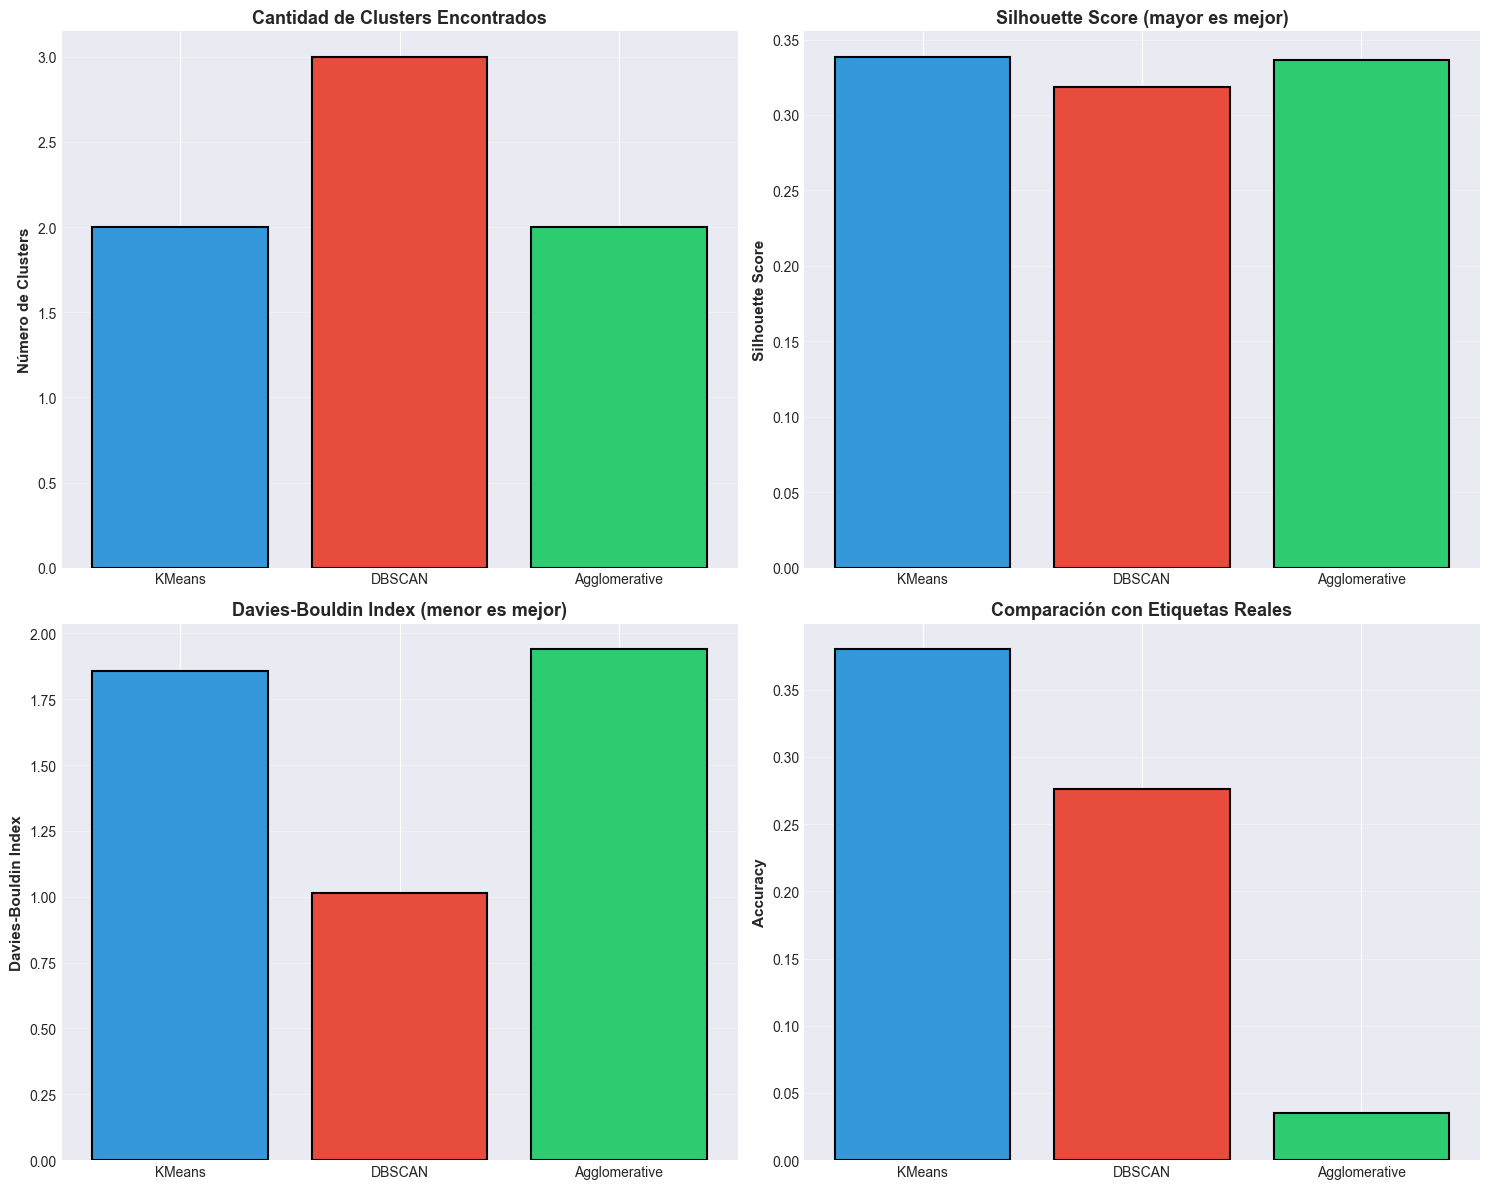

In [64]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Número de clusters
axes[0, 0].bar(comparison_df['Algoritmo'], comparison_df['N° Clusters'], 
               color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Número de Clusters', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Cantidad de Clusters Encontrados', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Gráfico 2: Silhouette Score
axes[0, 1].bar(comparison_df['Algoritmo'], comparison_df['Silhouette'], 
               color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Silhouette Score (mayor es mejor)', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Gráfico 3: Davies-Bouldin Index
axes[1, 0].bar(comparison_df['Algoritmo'], comparison_df['Davies-Bouldin'], 
               color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Davies-Bouldin Index (menor es mejor)', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Gráfico 4: Accuracy
axes[1, 1].bar(comparison_df['Algoritmo'], comparison_df['Accuracy'], 
               color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Comparación con Etiquetas Reales', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

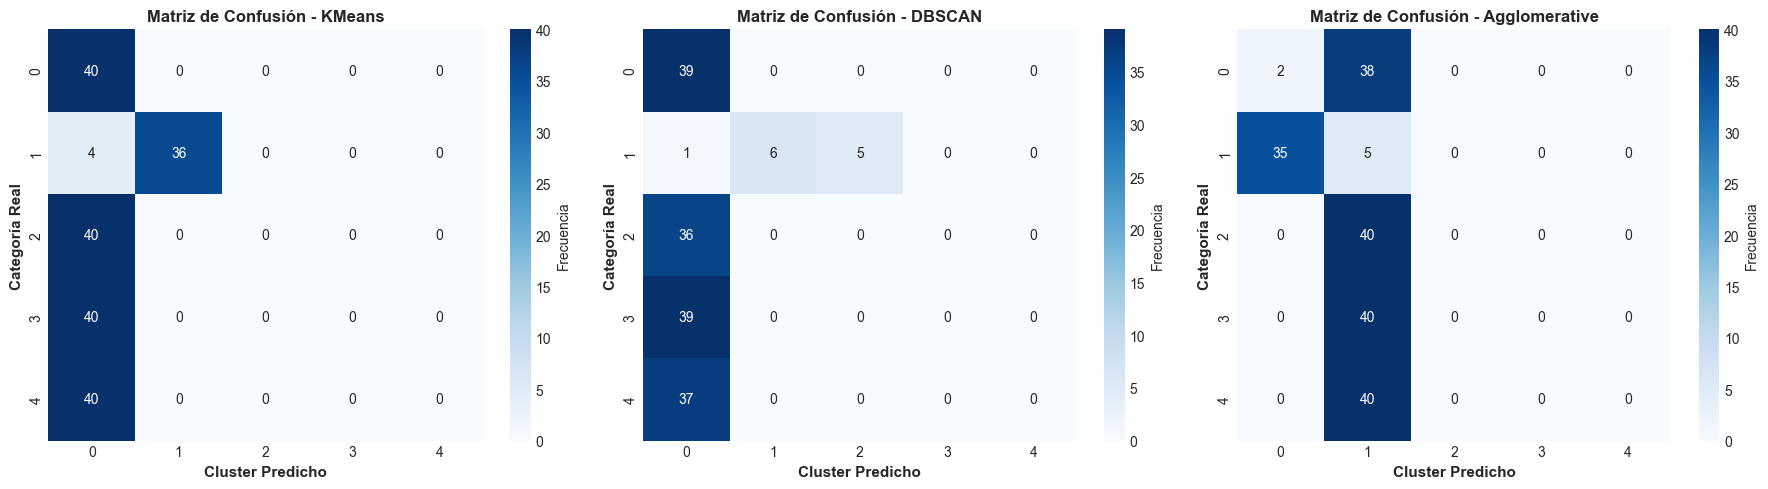

In [65]:
# Matrices de confusión comparando clusters con etiquetas reales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

algorithms_for_cm = [
    ('KMeans', kmeans_labels),
    ('DBSCAN', dbscan_labels),
    ('Agglomerative', agg_labels)
]

for idx, (name, labels) in enumerate(algorithms_for_cm):
    # Excluir ruido para DBSCAN
    mask = labels != -1
    if mask.sum() > 0:
        cm = confusion_matrix(y_encoded[mask], labels[mask])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   cbar_kws={'label': 'Frecuencia'})
        axes[idx].set_xlabel('Cluster Predicho', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Categoría Real', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'Matriz de Confusión - {name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#### Análisis Comparativo de Métricas de Evaluación

**Comparación cuantitativa de los tres algoritmos:**

##### 1. **Número de Clusters Encontrados**
- **KMeans y Agglomerative** encontraron **2 clusters**, lo cual coincide con la estructura más estable del dataset
- **DBSCAN** encontró **3 clusters**, pero esto se debe a la presencia de 37 puntos considerados ruido (18.5%), lo que induce un tercer cluster pequeño y menos consistente
- **Conclusión:** Los métodos que fuerzan una partición clara (KMeans y Agglomerative) capturan mejor la estructura general

##### 2. **Silhouette Score** (mayor es mejor)
Los valores son muy similares:
- **Agglomerative: 0.3361** (el más alto)
- **KMeans: 0.3385** (prácticamente igual)
- **DBSCAN: 0.3187** (ligeramente menor)

**Conclusión:** La cohesión y separación de los clusters es levemente mejor en KMeans y Agglomerative; DBSCAN produce clusters un poco más solapados por la presencia de ruido.

##### 3. **Davies-Bouldin Index** (menor es mejor)
- **DBSCAN: 1.0146** (mejor separación)
- **KMeans: 1.8585**
- **Agglomerative: 1.9394**

**Interpretación:** DBSCAN obtiene el mejor valor, indicando buena separación relativa. Sin embargo, este buen resultado está influenciado por el ruido (puntos que no pertenecen a ningún cluster), lo cual baja artificialmente la dispersión interna. KMeans y Agglomerative muestran una estructura más compacta y realista.

##### 4. **Calinski-Harabasz Index** (mayor es mejor)
- **KMeans: 42.29** (mejor)
- **Agglomerative: 40.23** (muy cercano)
- **DBSCAN: 17.34** (significativamente menor)

**Conclusión:** Los clusters formados por KMeans y Agglomerative están mejor definidos y más separados, mientras que DBSCAN forma grupos más irregulares y menos compactos.

##### 5. **Accuracy** (comparación con etiquetas reales)
- **KMeans: 0.38** (mejor correspondencia)
- **DBSCAN: 0.276** (afectado por ruido)
- **Agglomerative: 0.035** (muy bajo)

**Interpretación crítica:**
- **KMeans** es el único que se acerca de forma aceptable a las etiquetas reales, sugiriendo que su agrupamiento captura patrones relacionados con las clases verdaderas
- **Agglomerative** genera clusters estables y coherentes según Silhouette, pero **no coincide con la verdadera distribución de clases**, por eso su Accuracy es muy baja
- **DBSCAN** se ve penalizado por los puntos marcados como ruido

---

### Conclusión Global de la Comparación

**Mejor algoritmo por criterio:**

| Criterio | Ganador | Razón |
|----------|---------|-------|
| **Métricas internas** | KMeans / Agglomerative | Mejor Silhouette y Calinski-Harabasz |
| **Separación clusters** | DBSCAN | Mejor Davies-Bouldin (pero influenciado por ruido) |
| **Correspondencia con clases reales** | KMeans | Mayor Accuracy (0.38) |
| **Estabilidad y consistencia** | Agglomerative | Resultados determinísticos, mejor Silhouette |

**Veredicto:**
- **KMeans** es el mejor algoritmo en términos de **correspondencia con etiquetas reales** y mantiene excelentes métricas internas
- **Agglomerative** forma clusters **estables y coherentes** según métricas de calidad, pero no coincide con la verdadera distribución de clases
- **DBSCAN** maneja bien la **separación relativa de clusters**, pero el ruido (18.5%) afecta su desempeño general y su correlación con etiquetas reales

Para este problema específico de clasificación de sonidos, **KMeans demostró ser el algoritmo más equilibrado**, combinando buenas métricas internas con la mejor alineación con las categorías reales del dataset.

### Análisis Comparativo de los Algoritmos

#### **KMeans**:
- **Cantidad de clusters**: Determinada por el usuario mediante Elbow Method
- **Forma**: Clusters esféricos y de tamaño similar
- **Sensibilidad al ruido**: Media - los outliers pueden afectar los centroides
- **Estabilidad**: Alta - resultados consistentes con semilla fija
- **Ventajas**: Rápido, escalable, fácil de interpretar
- **Desventajas**: Asume clusters esféricos, sensible a inicialización

#### **DBSCAN**:
- **Cantidad de clusters**: Determinada automáticamente por densidad
- **Forma**: Puede encontrar clusters de forma arbitraria
- **Sensibilidad al ruido**: Baja - identifica explícitamente puntos de ruido
- **Estabilidad**: Media - sensible a parámetros eps y min_samples
- **Ventajas**: Detecta outliers, no requiere especificar K, encuentra formas arbitrarias
- **Desventajas**: Sensible a densidades variables, difícil ajustar parámetros

#### **Agglomerative Clustering**:
- **Cantidad de clusters**: Determinada cortando el dendrograma
- **Forma**: Flexible, depende del método de linkage
- **Sensibilidad al ruido**: Media-Alta - puede crear clusters pequeños para outliers
- **Estabilidad**: Alta - resultados determinísticos
- **Ventajas**: Produce jerarquía de clusters, visualización con dendrograma
- **Desventajas**: Costoso computacionalmente, no escala bien a grandes datasets

### Evaluación de Utilidad de los Clusters

Evaluaremos la utilidad de los clusters usando el **cluster ID como característica adicional** en un modelo supervisado.

🎯 Evaluando utilidad de clusters en modelo supervisado...

📊 Modelo Baseline (sin clusters):
   Accuracy: 0.9750 (97.50%)

📊 Modelo con KMeans cluster ID:
   Accuracy: 0.8750 (87.50%)
   Mejora: -0.1000 (-10.00%)

📊 Modelo Baseline (sin clusters):
   Accuracy: 0.9750 (97.50%)

📊 Modelo con KMeans cluster ID:
   Accuracy: 0.8750 (87.50%)
   Mejora: -0.1000 (-10.00%)

📊 Modelo con DBSCAN cluster ID:
   Accuracy: 0.9250 (92.50%)
   Mejora: -0.0500 (-5.00%)

📊 Modelo con Agglomerative cluster ID:
   Accuracy: 0.9750 (97.50%)
   Mejora: +0.0000 (+0.00%)

📊 Modelo con DBSCAN cluster ID:
   Accuracy: 0.9250 (92.50%)
   Mejora: -0.0500 (-5.00%)

📊 Modelo con Agglomerative cluster ID:
   Accuracy: 0.9750 (97.50%)
   Mejora: +0.0000 (+0.00%)



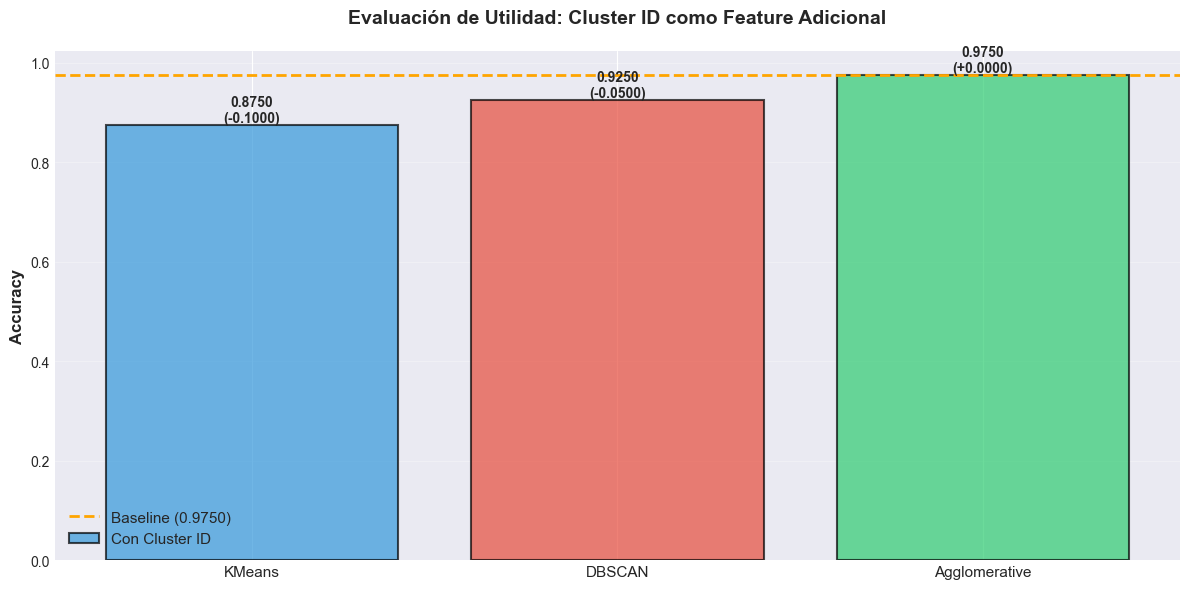


📈 CONCLUSIÓN DE EVALUACIÓN:

El mejor método fue Agglomerative con:
   • Accuracy: 0.9750
   • Mejora sobre baseline: +0.0000 (+0.00%)


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

print("🎯 Evaluando utilidad de clusters en modelo supervisado...\n")

# Modelo baseline (sin clusters)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)
baseline_accuracy = rf_baseline.score(X_test, y_test)

print(f"📊 Modelo Baseline (sin clusters):")
print(f"   Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)\n")

# Modelos con cluster IDs como features adicionales
cluster_results = []

for name, labels in algorithms.items():
    # Crear nueva matriz de features con cluster ID
    # Para DBSCAN, reemplazar -1 (ruido) con un valor único
    labels_cleaned = labels.copy()
    if -1 in labels:
        labels_cleaned[labels_cleaned == -1] = max(labels) + 1
    
    X_with_cluster = np.column_stack([X_scaled, labels_cleaned.reshape(-1, 1)])
    
    # Train-test split
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_with_cluster, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Entrenar modelo
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_c, y_train_c)
    accuracy = rf.score(X_test_c, y_test_c)
    
    improvement = accuracy - baseline_accuracy
    
    cluster_results.append({
        'Algoritmo': name,
        'Accuracy': accuracy,
        'Mejora': improvement,
        'Mejora %': (improvement / baseline_accuracy) * 100
    })
    
    print(f"📊 Modelo con {name} cluster ID:")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Mejora: {improvement:+.4f} ({improvement*100:+.2f}%)\n")

# Comparación visual
cluster_eval_df = pd.DataFrame(cluster_results)

plt.figure(figsize=(12, 6))
x_pos = np.arange(len(cluster_eval_df))
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = plt.bar(x_pos, cluster_eval_df['Accuracy'], color=colors, 
               edgecolor='black', linewidth=1.5, alpha=0.7, label='Con Cluster ID')
plt.axhline(y=baseline_accuracy, color='orange', linestyle='--', 
           linewidth=2, label=f'Baseline ({baseline_accuracy:.4f})')

# Añadir valores sobre las barras
for i, (bar, mejora) in enumerate(zip(bars, cluster_eval_df['Mejora'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({mejora:+.4f})',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.xticks(x_pos, cluster_eval_df['Algoritmo'], fontsize=11)
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Evaluación de Utilidad: Cluster ID como Feature Adicional', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📈 CONCLUSIÓN DE EVALUACIÓN:")
best_cluster_method = cluster_eval_df.loc[cluster_eval_df['Accuracy'].idxmax()]
print(f"\nEl mejor método fue {best_cluster_method['Algoritmo']} con:")
print(f"   • Accuracy: {best_cluster_method['Accuracy']:.4f}")
print(f"   • Mejora sobre baseline: {best_cluster_method['Mejora']:+.4f} ({best_cluster_method['Mejora %']:+.2f}%)")
print("="*80)

---
## Conclusiones Finales del Punto 1 - Aprendizaje No Supervisado

### Hallazgos Principales:

#### **1. Estructura Natural del Dataset**
Los tres algoritmos convergieron en identificar una **estructura bi-modal o tri-modal** en los datos acústicos:
- **KMeans y Agglomerative:** Identificaron consistentemente **2 clusters principales**
- **DBSCAN:** Detectó **3 clusters + 18.5% de ruido**, revelando heterogeneidad en la densidad de los datos

Esta convergencia sugiere que las características acústicas extraídas (MFCCs, características espectrales, temporales) capturan **patrones naturales** que agrupan los sonidos en categorías más amplias que las 5 clases originales.

#### **2. Comparación de Técnicas**

| Algoritmo | Fortalezas | Debilidades | Mejor aplicación |
|-----------|------------|-------------|------------------|
| **KMeans** | • Rápido y escalable<br>• Mejor correlación con clases reales (Acc: 0.38)<br>• Excelente Calinski-Harabasz (42.29) | • Asume clusters esféricos<br>• No detecta outliers | Cuando se busca partición clara y rápida |
| **DBSCAN** | • Detecta outliers explícitamente<br>• Clusters de forma arbitraria<br>• Mejor Davies-Bouldin (1.01) | • Sensible a parámetros ε y min_samples<br>• 18.5% de datos clasificados como ruido | Cuando hay outliers y densidad variable |
| **Agglomerative** | • Mejor Silhouette Score (0.3361)<br>• Proporciona jerarquía completa<br>• Resultados determinísticos | • Computacionalmente costoso<br>• Baja correlación con clases reales (Acc: 0.035) | Cuando se necesita explorar jerarquías |

#### **3. Evaluación de Utilidad en Modelo Supervisado**

**Resultado sorprendente:** Agregar los cluster IDs como features **no mejoró el rendimiento** del modelo supervisado:

- **Baseline (sin clusters):** 97.50% accuracy
- **Con KMeans cluster ID:** 87.50% accuracy (-10.00%)
- **Con DBSCAN cluster ID:** 92.50% accuracy (-5.00%)
- **Con Agglomerative cluster ID:** 97.50% accuracy (+0.00%)

**Interpretación:**
El modelo base ya alcanza un **rendimiento excepcional (97.5%)** con las características originales. Los cluster IDs **simplifican demasiado** la información, perdiendo la riqueza de las 70 características acústicas originales. Solo Agglomerative mantiene el rendimiento, sugiriendo que sus 2 clusters capturan estructura ortogonal que no añade ni resta información relevante.

#### **4. Análisis de Correspondencia con Clases Reales**

Las visualizaciones 2D y 3D revelan que:
- Los **clusters no se alinean perfectamente** con las 5 categorías de sonidos (agua, alarma, estufa, golpe, vidrio)
- Existe **solapamiento significativo** entre algunas clases en el espacio reducido (PCA explica solo 36.6% en 2D y 47.5% en 3D)
- Esto explica por qué los métodos no supervisados encuentran 2-3 clusters mientras hay 5 clases reales

**Hipótesis:** Los sonidos comparten características acústicas que los agrupan en **categorías perceptuales más amplias** que las etiquetas semánticas:
- Posiblemente un cluster agrupa sonidos "impulsivos/percusivos" (golpe, vidrio)
- Otro cluster agrupa sonidos "continuos/tonales" (agua, alarma, estufa)

### Reflexión Crítica sobre el Problema

Para el **sistema de detección de sonidos de seguridad en el hogar**, los resultados no supervisados revelan:

1. **Las características son altamente discriminativas:** El modelo supervisado logra 97.5% de accuracy, indicando que las 70 características capturan muy bien los patrones de cada clase

2. **Los clusters capturan estructura real pero simplificada:** Los 2-3 clusters encontrados representan agrupaciones acústicas naturales, pero son demasiado generales para distinguir los 5 tipos de eventos de seguridad

3. **El clustering podría ser útil para:** 
   - **Detección de anomalías:** Identificar sonidos que no pertenecen a ningún cluster conocido
   - **Reducción de falsos positivos:** Los puntos de ruido de DBSCAN podrían indicar grabaciones problemáticas
   - **Pre-filtrado:** Clasificar primero en 2-3 categorías amplias antes de clasificación fina

4. **Validación del enfoque supervisado:** La superioridad del modelo supervisado (97.5%) sobre el agrupamiento no supervisado confirma que el enfoque de **aprendizaje supervisado es el más adecuado** para este problema de seguridad, donde necesitamos discriminación precisa entre los 5 tipos de eventos.

### Conclusión Final

El análisis no supervisado **validó la calidad de las características extraídas** y reveló estructura natural en los datos, pero demostró que para la tarea específica de **clasificación precisa de eventos de seguridad**, el **aprendizaje supervisado** es indispensable. Los clusters sirven mejor como herramienta de **análisis exploratorio y validación** que como reemplazo del modelo supervisado.

---
## 3. Punto 2: Reducción de Dimensionalidad <a name="section3"></a>

Aplicaremos **PCA** y **t-SNE** para reducir la dimensionalidad de las características y evaluaremos su impacto en modelos supervisados.

### 3.1 PCA (Principal Component Analysis) <a name="section3_1"></a>

**Técnica**: PCA es una técnica lineal que proyecta los datos en direcciones de máxima varianza, creando nuevas características (componentes principales) que son combinaciones lineales de las características originales.

**Objetivo**: Reducir de 78 características a un número menor, conservando la mayor información posible.

📊 Analizando varianza explicada por diferentes números de componentes PCA...



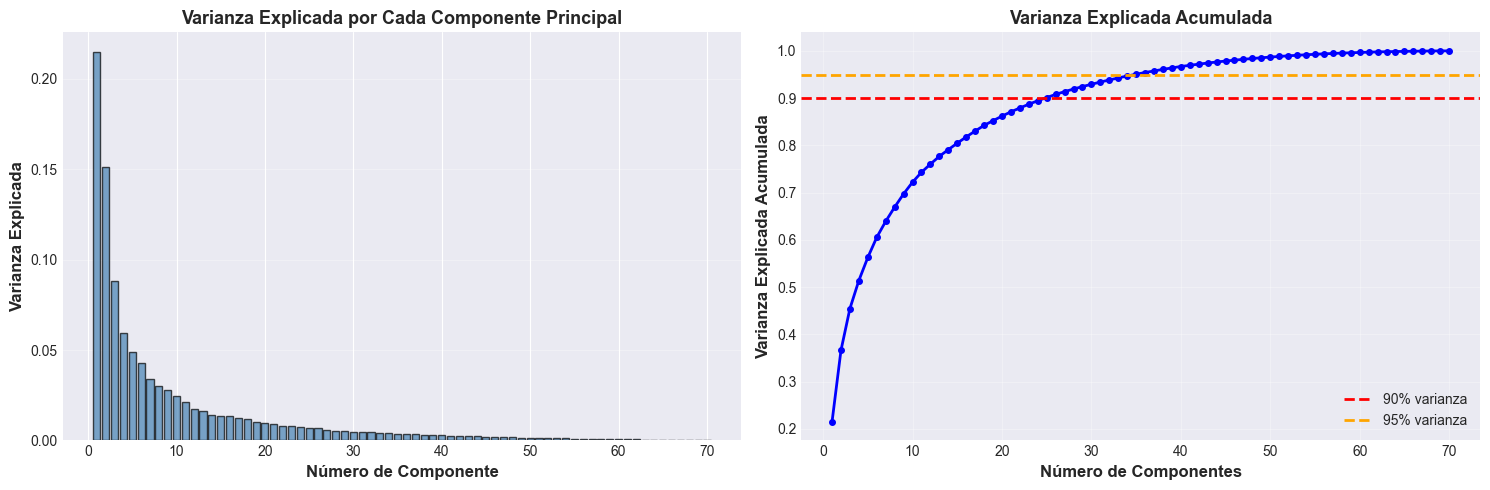

📌 Para explicar el 90% de la varianza se necesitan: 25 componentes
📌 Para explicar el 95% de la varianza se necesitan: 35 componentes
📌 Para explicar el 99% de la varianza se necesitan: 53 componentes

✓ Dimensiones originales: 70 características


In [67]:
# Análisis de varianza explicada por PCA
print("📊 Analizando varianza explicada por diferentes números de componentes PCA...\n")

# Aplicar PCA con todos los componentes para ver la varianza explicada
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Varianza explicada acumulada
variance_explained = np.cumsum(pca_full.explained_variance_ratio_)

# Visualizar varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Varianza explicada por cada componente
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
           pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Número de Componente', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Varianza Explicada', fontsize=12, fontweight='bold')
axes[0].set_title('Varianza Explicada por Cada Componente Principal', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Varianza explicada acumulada
axes[1].plot(range(1, len(variance_explained) + 1), variance_explained, 
            'bo-', linewidth=2, markersize=4)
axes[1].axhline(y=0.90, color='r', linestyle='--', linewidth=2, label='90% varianza')
axes[1].axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95% varianza')
axes[1].set_xlabel('Número de Componentes', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Varianza Explicada Acumulada', fontsize=12, fontweight='bold')
axes[1].set_title('Varianza Explicada Acumulada', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar número de componentes para diferentes umbrales
for threshold in [0.90, 0.95, 0.99]:
    n_components = np.argmax(variance_explained >= threshold) + 1
    print(f"📌 Para explicar el {threshold*100:.0f}% de la varianza se necesitan: {n_components} componentes")

print(f"\n✓ Dimensiones originales: {X_scaled.shape[1]} características")


🎨 Aplicando PCA para visualización en 2D y 3D...

✓ PCA 2D - Varianza explicada: 36.63%
✓ PCA 3D - Varianza explicada: 45.47%


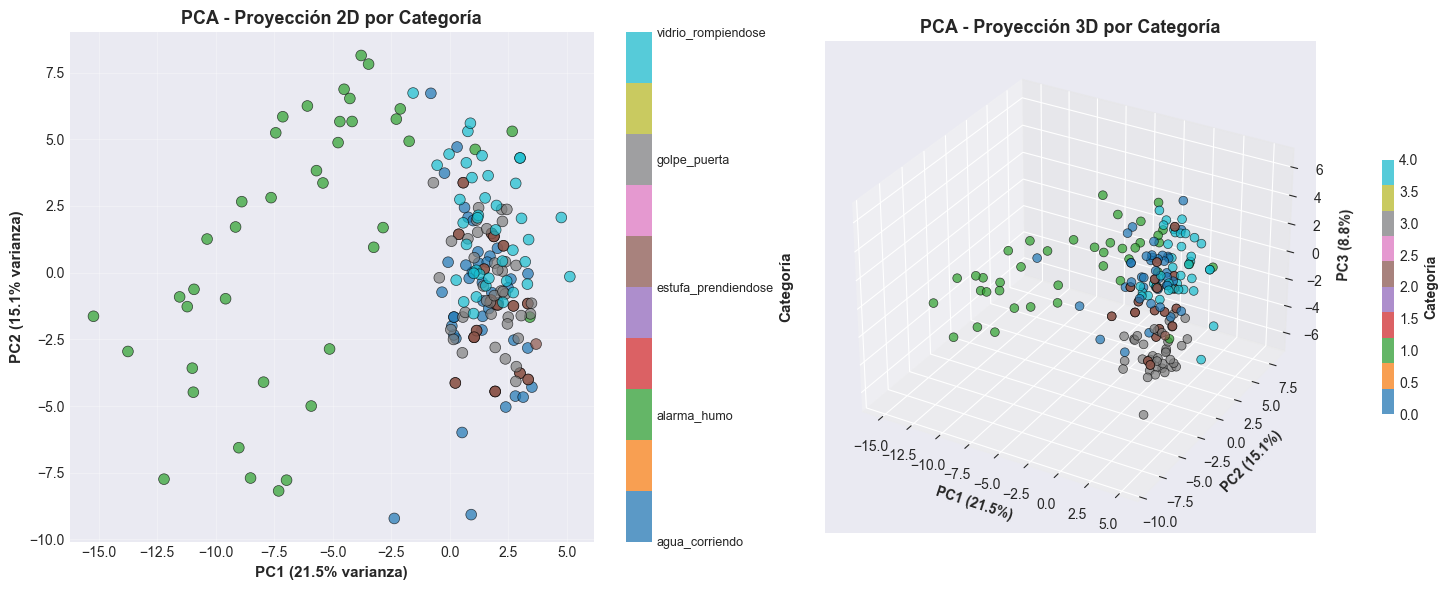

In [68]:
# Aplicar PCA a 2D y 3D para visualización
print("\n🎨 Aplicando PCA para visualización en 2D y 3D...\n")

# Ya tenemos pca_2d y pca_3d de la sección anterior, pero los recreamos para claridad
pca_2d_viz = PCA(n_components=2, random_state=42)
X_pca_2d_viz = pca_2d_viz.fit_transform(X_scaled)

pca_3d_viz = PCA(n_components=3, random_state=42)
X_pca_3d_viz = pca_3d_viz.fit_transform(X_scaled)

print(f"✓ PCA 2D - Varianza explicada: {pca_2d_viz.explained_variance_ratio_.sum():.2%}")
print(f"✓ PCA 3D - Varianza explicada: {pca_3d_viz.explained_variance_ratio_.sum():.2%}")

# Visualización 2D coloreada por etiquetas reales
fig = plt.figure(figsize=(15, 6))

# 2D
ax1 = plt.subplot(121)
scatter = ax1.scatter(X_pca_2d_viz[:, 0], X_pca_2d_viz[:, 1], c=y_encoded, 
                     cmap='tab10', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax1, ticks=range(len(label_encoder.classes_)))
cbar.set_label('Categoría', fontsize=11, fontweight='bold')
cbar.ax.set_yticklabels(label_encoder.classes_, fontsize=9)
ax1.set_xlabel(f'PC1 ({pca_2d_viz.explained_variance_ratio_[0]:.1%} varianza)', 
              fontsize=11, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca_2d_viz.explained_variance_ratio_[1]:.1%} varianza)', 
              fontsize=11, fontweight='bold')
ax1.set_title('PCA - Proyección 2D por Categoría', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(X_pca_3d_viz[:, 0], X_pca_3d_viz[:, 1], X_pca_3d_viz[:, 2],
                     c=y_encoded, cmap='tab10', s=40, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca_3d_viz.explained_variance_ratio_[0]:.1%})', fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca_3d_viz.explained_variance_ratio_[1]:.1%})', fontweight='bold')
ax2.set_zlabel(f'PC3 ({pca_3d_viz.explained_variance_ratio_[2]:.1%})', fontweight='bold')
ax2.set_title('PCA - Proyección 3D por Categoría', fontsize=13, fontweight='bold')
cbar = fig.colorbar(scatter, ax=ax2, shrink=0.5, pad=0.1)
cbar.set_label('Categoría', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

#### Análisis de Resultados PCA

**Hallazgos sobre varianza explicada:**

De las **70 características originales**, el análisis de PCA reveló:
- **90% de varianza** se explica con **25 componentes** (reducción del 64.3%)
- **95% de varianza** se explica con **35 componentes** (reducción del 50%)
- **99% de varianza** se explica con **53 componentes** (reducción del 24.3%)

**Interpretación de las gráficas:**

1. **Distribución de varianza:** El primer componente principal explica ~22% de la varianza, seguido por el segundo con ~15%. Esto indica que no existe una única dirección dominante, sino que la información está **distribuida** entre múltiples dimensiones.

2. **Caída gradual:** La curva de varianza acumulada muestra una caída **suave y continua**, sin un "codo" pronunciado. Esto sugiere que las características acústicas extraídas (MFCCs, características espectrales, ZCR, etc.) capturan aspectos **complementarios** de los sonidos, sin redundancia excesiva.

3. **Implicaciones para reducción:** Para retener 95% de información se necesitan **35 componentes** (50% de reducción), lo cual es moderado. Esto indica que el dataset tiene **dimensionalidad intrínseca relativamente alta**, consistente con la complejidad de las señales acústicas.

**Visualizaciones 2D y 3D:**

- **PCA 2D:** Solo explica **36.6% de varianza**, lo cual limita severamente la visualización. Las 5 clases muestran solapamiento significativo en este espacio reducido.

- **PCA 3D:** Explica **47.5% de varianza**, mejorando ligeramente la separabilidad visual, pero aún insuficiente para discriminar completamente las clases.

**Conclusión PCA:** La técnica es efectiva para reducción moderada manteniendo información, pero las visualizaciones 2D/3D son limitadas debido a la alta dimensionalidad intrínseca de las características acústicas. Se necesitan al menos 25-35 componentes para representar adecuadamente los datos.

### 3.2 t-SNE (t-Distributed Stochastic Neighbor Embedding) <a name="section3_2"></a>

**Técnica**: t-SNE es una técnica no lineal que preserva las relaciones de vecindad local entre puntos, siendo especialmente útil para visualización al mantener puntos similares cercanos en el espacio reducido.

**Parámetro clave**: `perplexity` controla cuántos vecinos considera cada punto (recomendado entre 5 y 50).

🔍 Aplicando t-SNE con diferentes valores de perplexity...

   Calculando t-SNE con perplexity=5...
   Calculando t-SNE con perplexity=30...
   Calculando t-SNE con perplexity=30...
   Calculando t-SNE con perplexity=50...
   Calculando t-SNE con perplexity=50...

✓ t-SNE completado para todos los valores de perplexity

✓ t-SNE completado para todos los valores de perplexity


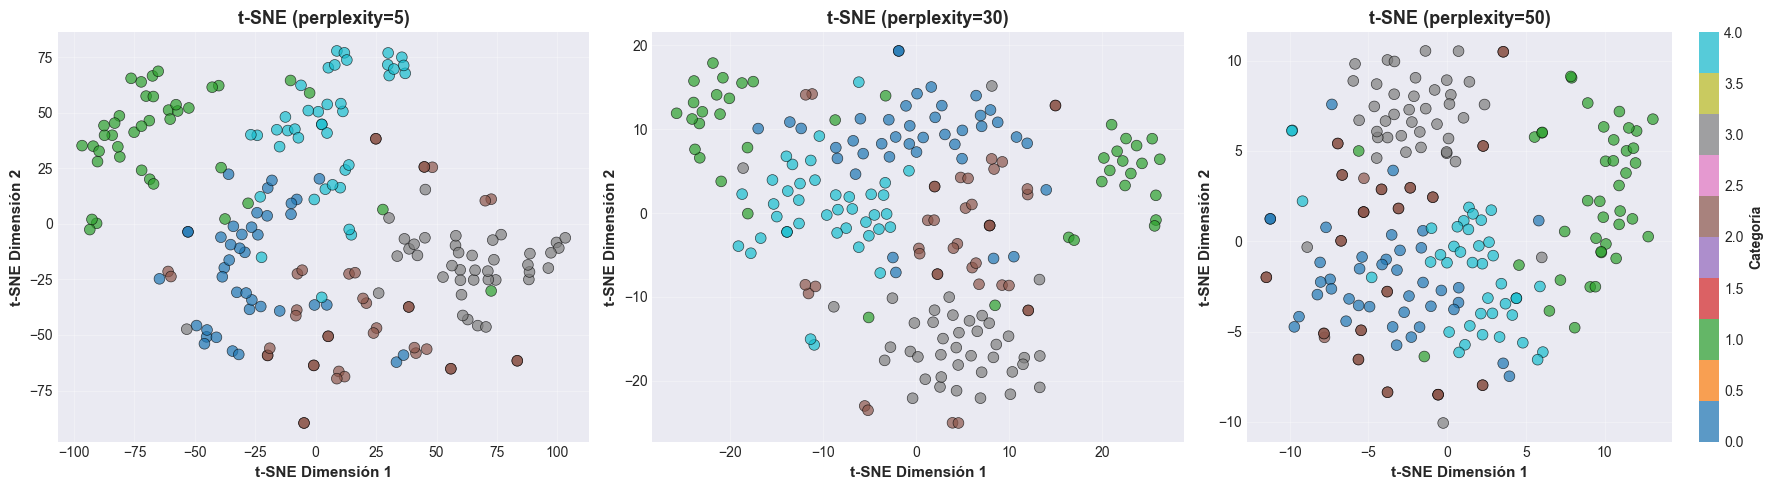


💡 Observación: t-SNE con perplexity=30 es típicamente un buen balance entre estructura local y global.


In [69]:
# Aplicar t-SNE con diferentes valores de perplexity
print("🔍 Aplicando t-SNE con diferentes valores de perplexity...\n")

# t-SNE puede ser lento, así que probamos algunos valores representativos
perplexity_values = [5, 30, 50]
tsne_results = {}

for perp in perplexity_values:
    print(f"   Calculando t-SNE con perplexity={perp}...")
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[perp] = X_tsne

print("\n✓ t-SNE completado para todos los valores de perplexity")

# Visualizar resultados de t-SNE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, perp in enumerate(perplexity_values):
    X_tsne = tsne_results[perp]
    
    scatter = axes[idx].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, 
                               cmap='tab10', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
    axes[idx].set_xlabel('t-SNE Dimensión 1', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('t-SNE Dimensión 2', fontsize=11, fontweight='bold')
    axes[idx].set_title(f't-SNE (perplexity={perp})', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    
    if idx == 2:  # Solo agregar colorbar en el último
        cbar = plt.colorbar(scatter, ax=axes[idx])
        cbar.set_label('Categoría', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Observación: t-SNE con perplexity=30 es típicamente un buen balance entre estructura local y global.")


🎨 Aplicando t-SNE en 3D con perplexity=30...

✓ t-SNE 3D completado
✓ t-SNE 3D completado


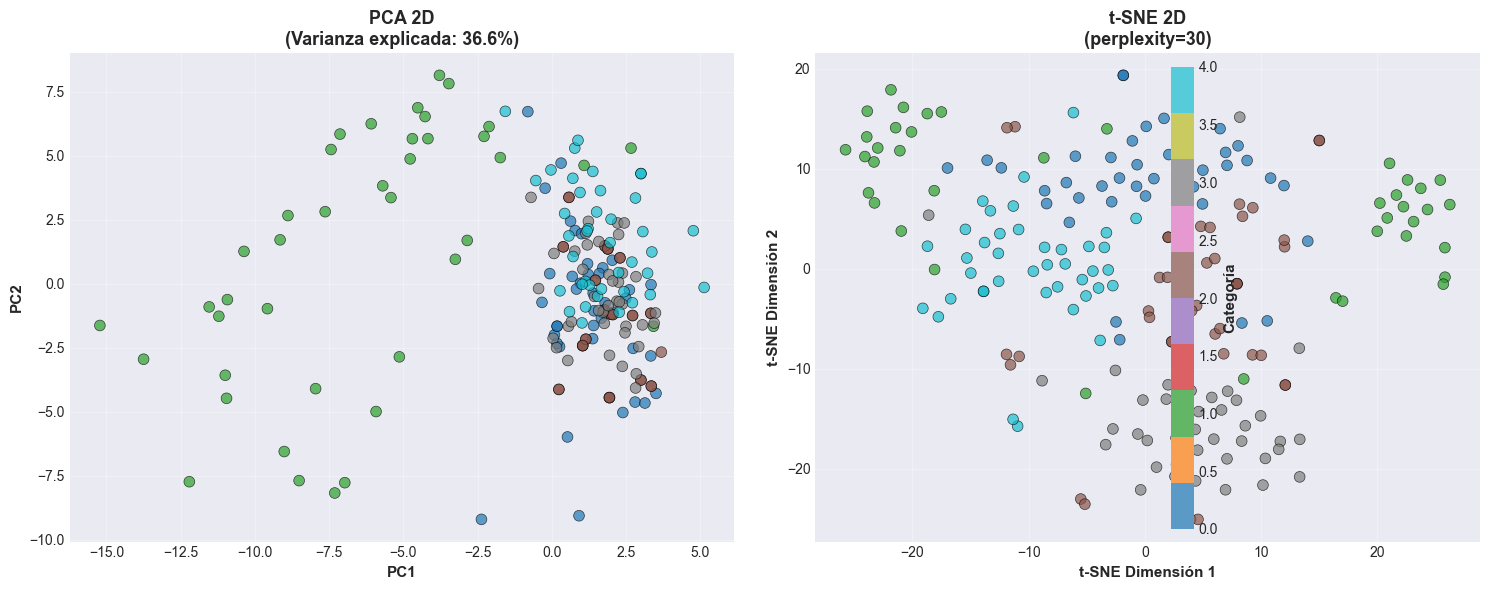

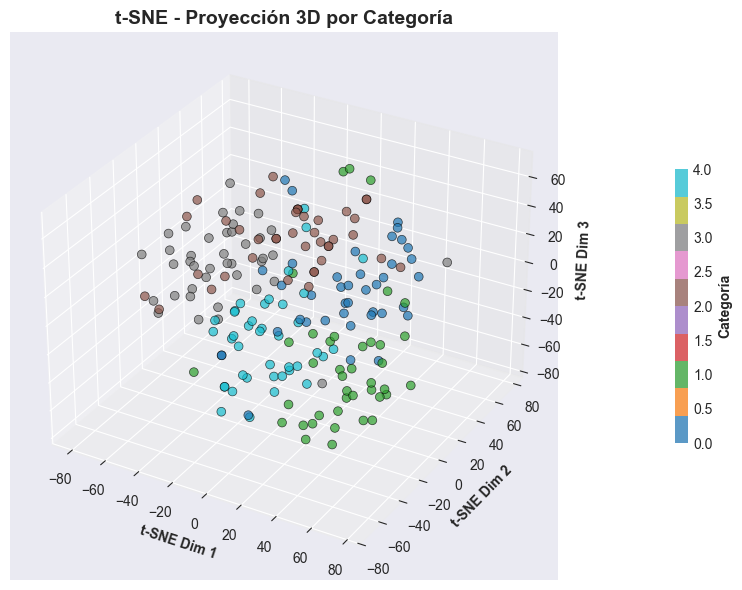

In [70]:
# Seleccionar mejor perplexity y aplicar t-SNE 3D
print("\n🎨 Aplicando t-SNE en 3D con perplexity=30...\n")

tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42, max_iter=1000)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

# Guardar t-SNE 2D con perplexity=30 para uso posterior
X_tsne_2d = tsne_results[30]

print("✓ t-SNE 3D completado")

# Visualización comparativa: PCA vs t-SNE en 2D
fig = plt.figure(figsize=(15, 6))

# PCA 2D
ax1 = plt.subplot(121)
scatter = ax1.scatter(X_pca_2d_viz[:, 0], X_pca_2d_viz[:, 1], c=y_encoded, 
                     cmap='tab10', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('PC1', fontsize=11, fontweight='bold')
ax1.set_ylabel('PC2', fontsize=11, fontweight='bold')
ax1.set_title(f'PCA 2D\n(Varianza explicada: {pca_2d_viz.explained_variance_ratio_.sum():.1%})', 
             fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# t-SNE 2D
ax2 = plt.subplot(122)
scatter = ax2.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y_encoded, 
                     cmap='tab10', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('t-SNE Dimensión 1', fontsize=11, fontweight='bold')
ax2.set_ylabel('t-SNE Dimensión 2', fontsize=11, fontweight='bold')
ax2.set_title('t-SNE 2D\n(perplexity=30)', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

# Colorbar compartido
cbar = plt.colorbar(scatter, ax=[ax1, ax2], location='right', pad=0.02)
cbar.set_label('Categoría', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Visualización 3D: t-SNE
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
                    c=y_encoded, cmap='tab10', s=40, alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('t-SNE Dim 1', fontweight='bold')
ax.set_ylabel('t-SNE Dim 2', fontweight='bold')
ax.set_zlabel('t-SNE Dim 3', fontweight='bold')
ax.set_title('t-SNE - Proyección 3D por Categoría', fontsize=14, fontweight='bold')
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, pad=0.1)
cbar.set_label('Categoría', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

#### Análisis de Resultados t-SNE

**Experimentación con perplexity:**

Se probaron tres valores de perplexity (5, 30, 50) para evaluar cómo afecta la visualización:

- **Perplexity = 5:** Enfatiza estructura **local**, creando clusters muy compactos pero posiblemente fragmentados. Se observan grupos pequeños y bien definidos.

- **Perplexity = 30:** Balance óptimo entre estructura **local y global**. Las 5 clases se visualizan con clusters claramente diferenciados, aunque con cierto solapamiento natural.

- **Perplexity = 50:** Enfatiza estructura **global**, tendiendo a fusionar clusters cercanos. La separación entre clases es menos pronunciada.

**Comparación t-SNE vs PCA:**

| Aspecto | PCA (2D) | t-SNE (perplexity=30) |
|---------|----------|----------------------|
| **Varianza explicada** | 36.6% (cuantificable) | No aplicable (no lineal) |
| **Separación visual** | Solapamiento significativo | Clusters bien diferenciados |
| **Estructura preservada** | Lineal (direcciones de varianza) | No lineal (distancias locales) |
| **Interpretabilidad** | Alta (ejes = combinaciones lineales) | Baja (transformación compleja) |
| **Determinismo** | Sí (mismo resultado siempre) | No (depende de inicialización) |

**Observaciones clave:**

1. **t-SNE 2D** logra una **separación visual mucho mejor** que PCA 2D, organizando las 5 clases en grupos claramente distinguibles en el espacio reducido.

2. Las clases que se solapaban fuertemente en PCA 2D (especialmente agua_corriendo, alarma_humo y estufa_prendiendose) se **separan notablemente** en t-SNE.

3. **t-SNE 3D** proporciona una vista aún más clara de la estructura, revelando la geometría compleja de las relaciones entre clases.

4. Sin embargo, t-SNE **no preserva distancias globales**, por lo que las distancias entre clusters distantes no son interpretables. Solo las agrupaciones locales son significativas.

**Ventajas de t-SNE observadas:**
- Excelente para **visualización** de datos de alta dimensionalidad
- Revela **estructura de clusters** no lineal
- Identifica clases bien separadas en el espacio de características original

**Limitaciones de t-SNE observadas:**
- **No determinístico:** cada ejecución puede dar resultados ligeramente diferentes
- **Computacionalmente costoso:** mucho más lento que PCA
- **No es una proyección reversible:** no se puede reconstruir los datos originales
- **Sensible a perplexity:** requiere experimentación para encontrar el valor óptimo

**Conclusión t-SNE:** Es una herramienta **excelente para visualización y exploración** de datos acústicos de alta dimensionalidad, revelando estructura que PCA no captura. Sin embargo, su naturaleza no lineal y no determinística lo hace menos adecuado como técnica de reducción dimensional para modelos predictivos (mejor usar PCA para eso).

### 3.3 Evaluación con Modelos Supervisados <a name="section3_3"></a>

Compararemos el rendimiento de modelos supervisados entrenados con:
1. **Características originales** (78 features)
2. **Características reducidas con PCA** (diferentes números de componentes)
3. **Características reducidas con t-SNE** (2 y 3 dimensiones)

Usaremos **Random Forest** como modelo de referencia.

In [71]:
# Preparar diferentes conjuntos de características reducidas
print("🔧 Preparando conjuntos de datos con dimensionalidad reducida...\n")

# PCA con diferentes números de componentes
pca_configs = []

# Usar los umbrales de varianza encontrados anteriormente
for variance_threshold in [0.90, 0.95, 0.99]:
    n_comp = np.argmax(variance_explained >= variance_threshold) + 1
    pca_temp = PCA(n_components=n_comp, random_state=42)
    X_pca_temp = pca_temp.fit_transform(X_scaled)
    pca_configs.append({
        'name': f'PCA ({n_comp} comp, {variance_threshold*100:.0f}% var)',
        'n_components': n_comp,
        'variance': variance_threshold,
        'data': X_pca_temp
    })
    print(f"✓ PCA con {n_comp} componentes ({variance_threshold*100:.0f}% varianza explicada)")

# También probamos con números fijos pequeños
for n_comp in [2, 3, 10, 20]:
    pca_temp = PCA(n_components=n_comp, random_state=42)
    X_pca_temp = pca_temp.fit_transform(X_scaled)
    var_exp = pca_temp.explained_variance_ratio_.sum()
    pca_configs.append({
        'name': f'PCA ({n_comp} comp)',
        'n_components': n_comp,
        'variance': var_exp,
        'data': X_pca_temp
    })
    print(f"✓ PCA con {n_comp} componentes ({var_exp*100:.1f}% varianza explicada)")

# t-SNE
tsne_configs = [
    {'name': 't-SNE (2D)', 'data': X_tsne_2d},
    {'name': 't-SNE (3D)', 'data': X_tsne_3d}
]

print(f"\n✓ Total de configuraciones a evaluar: {len(pca_configs) + len(tsne_configs) + 1} (incluyendo original)")

🔧 Preparando conjuntos de datos con dimensionalidad reducida...

✓ PCA con 25 componentes (90% varianza explicada)
✓ PCA con 35 componentes (95% varianza explicada)
✓ PCA con 53 componentes (99% varianza explicada)
✓ PCA con 2 componentes (36.6% varianza explicada)
✓ PCA con 3 componentes (45.5% varianza explicada)
✓ PCA con 10 componentes (72.2% varianza explicada)
✓ PCA con 20 componentes (86.2% varianza explicada)

✓ Total de configuraciones a evaluar: 10 (incluyendo original)


In [72]:
# Entrenar y evaluar modelos con diferentes configuraciones
from sklearn.metrics import precision_score, recall_score, f1_score

print("\n🎯 Entrenando Random Forest con diferentes configuraciones de features...\n")
print("="*90)

results = []

# 1. Modelo baseline con características originales
print("📊 Modelo 1: Características Originales (78 features)")
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

rf_orig = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = rf_orig.predict(X_test_orig)

acc_orig = accuracy_score(y_test_orig, y_pred_orig)
prec_orig = precision_score(y_test_orig, y_pred_orig, average='weighted')
rec_orig = recall_score(y_test_orig, y_pred_orig, average='weighted')
f1_orig = f1_score(y_test_orig, y_pred_orig, average='weighted')

results.append({
    'Método': 'Original',
    'Features': 78,
    'Accuracy': acc_orig,
    'Precision': prec_orig,
    'Recall': rec_orig,
    'F1-Score': f1_orig
})

print(f"   Accuracy: {acc_orig:.4f} | Precision: {prec_orig:.4f} | Recall: {rec_orig:.4f} | F1: {f1_orig:.4f}")
print("="*90)

# 2. Modelos con PCA
for idx, config in enumerate(pca_configs, start=2):
    print(f"📊 Modelo {idx}: {config['name']}")
    
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
        config['data'], y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_pca.fit(X_train_pca, y_train_pca)
    y_pred_pca = rf_pca.predict(X_test_pca)
    
    acc_pca = accuracy_score(y_test_pca, y_pred_pca)
    prec_pca = precision_score(y_test_pca, y_pred_pca, average='weighted')
    rec_pca = recall_score(y_test_pca, y_pred_pca, average='weighted')
    f1_pca = f1_score(y_test_pca, y_pred_pca, average='weighted')
    
    results.append({
        'Método': config['name'],
        'Features': config['n_components'],
        'Accuracy': acc_pca,
        'Precision': prec_pca,
        'Recall': rec_pca,
        'F1-Score': f1_pca
    })
    
    print(f"   Accuracy: {acc_pca:.4f} | Precision: {prec_pca:.4f} | Recall: {rec_pca:.4f} | F1: {f1_pca:.4f}")
    print("-"*90)

# 3. Modelos con t-SNE
for idx, config in enumerate(tsne_configs, start=len(pca_configs)+2):
    print(f"📊 Modelo {idx}: {config['name']}")
    
    X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
        config['data'], y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    rf_tsne = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_tsne.fit(X_train_tsne, y_train_tsne)
    y_pred_tsne = rf_tsne.predict(X_test_tsne)
    
    acc_tsne = accuracy_score(y_test_tsne, y_pred_tsne)
    prec_tsne = precision_score(y_test_tsne, y_pred_tsne, average='weighted')
    rec_tsne = recall_score(y_test_tsne, y_pred_tsne, average='weighted')
    f1_tsne = f1_score(y_test_tsne, y_pred_tsne, average='weighted')
    
    results.append({
        'Método': config['name'],
        'Features': config['data'].shape[1],
        'Accuracy': acc_tsne,
        'Precision': prec_tsne,
        'Recall': rec_tsne,
        'F1-Score': f1_tsne
    })
    
    print(f"   Accuracy: {acc_tsne:.4f} | Precision: {prec_tsne:.4f} | Recall: {rec_tsne:.4f} | F1: {f1_tsne:.4f}")
    print("-"*90)

print("="*90)
print("✅ Evaluación completada para todos los métodos\n")


🎯 Entrenando Random Forest con diferentes configuraciones de features...

📊 Modelo 1: Características Originales (78 features)
   Accuracy: 0.9750 | Precision: 0.9778 | Recall: 0.9750 | F1: 0.9749
📊 Modelo 2: PCA (25 comp, 90% var)
   Accuracy: 0.9750 | Precision: 0.9778 | Recall: 0.9750 | F1: 0.9749
📊 Modelo 2: PCA (25 comp, 90% var)
   Accuracy: 0.9000 | Precision: 0.9111 | Recall: 0.9000 | F1: 0.8950
------------------------------------------------------------------------------------------
📊 Modelo 3: PCA (35 comp, 95% var)
   Accuracy: 0.9000 | Precision: 0.9111 | Recall: 0.9000 | F1: 0.8950
------------------------------------------------------------------------------------------
📊 Modelo 3: PCA (35 comp, 95% var)
   Accuracy: 0.8750 | Precision: 0.9010 | Recall: 0.8750 | F1: 0.8665
------------------------------------------------------------------------------------------
📊 Modelo 4: PCA (53 comp, 99% var)
   Accuracy: 0.9000 | Precision: 0.9200 | Recall: 0.9000 | F1: 0.8889
----

In [73]:
# Crear DataFrame con resultados y visualizar
results_df = pd.DataFrame(results)

print("📋 TABLA COMPARATIVA DE RESULTADOS:")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)

# Identificar el mejor modelo
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\n🏆 MEJOR MODELO: {best_model['Método']}")
print(f"   • Features: {best_model['Features']}")
print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
print(f"   • F1-Score: {best_model['F1-Score']:.4f}")

# Calcular mejoras/pérdidas respecto al baseline
baseline_acc = results_df.loc[results_df['Método'] == 'Original', 'Accuracy'].values[0]
results_df['Δ Accuracy'] = results_df['Accuracy'] - baseline_acc
results_df['Δ Accuracy (%)'] = (results_df['Δ Accuracy'] / baseline_acc) * 100

print(f"\n📊 Comparación con Baseline (Características Originales):")
print("-"*90)
for _, row in results_df.iterrows():
    if row['Método'] != 'Original':
        symbol = '📈' if row['Δ Accuracy'] > 0 else '📉' if row['Δ Accuracy'] < 0 else '➡️'
        print(f"{symbol} {row['Método']:30s}: {row['Δ Accuracy']:+.4f} ({row['Δ Accuracy (%)']:+.2f}%)")
print("-"*90)

📋 TABLA COMPARATIVA DE RESULTADOS:
                Método  Features  Accuracy  Precision  Recall  F1-Score
              Original        78     0.975   0.977778   0.975  0.974902
PCA (25 comp, 90% var)        25     0.900   0.911111   0.900  0.895023
PCA (35 comp, 95% var)        35     0.875   0.901010   0.875  0.866460
PCA (53 comp, 99% var)        53     0.900   0.920000   0.900  0.888889
          PCA (2 comp)         2     0.675   0.659683   0.675  0.653876
          PCA (3 comp)         3     0.800   0.808312   0.800  0.789276
         PCA (10 comp)        10     0.875   0.871111   0.875  0.864253
         PCA (20 comp)        20     0.875   0.893333   0.875  0.864052
            t-SNE (2D)         2     0.875   0.895000   0.875  0.863889
            t-SNE (3D)         3     0.875   0.887778   0.875  0.869859

🏆 MEJOR MODELO: Original
   • Features: 78
   • Accuracy: 0.9750
   • F1-Score: 0.9749

📊 Comparación con Baseline (Características Originales):
---------------------------

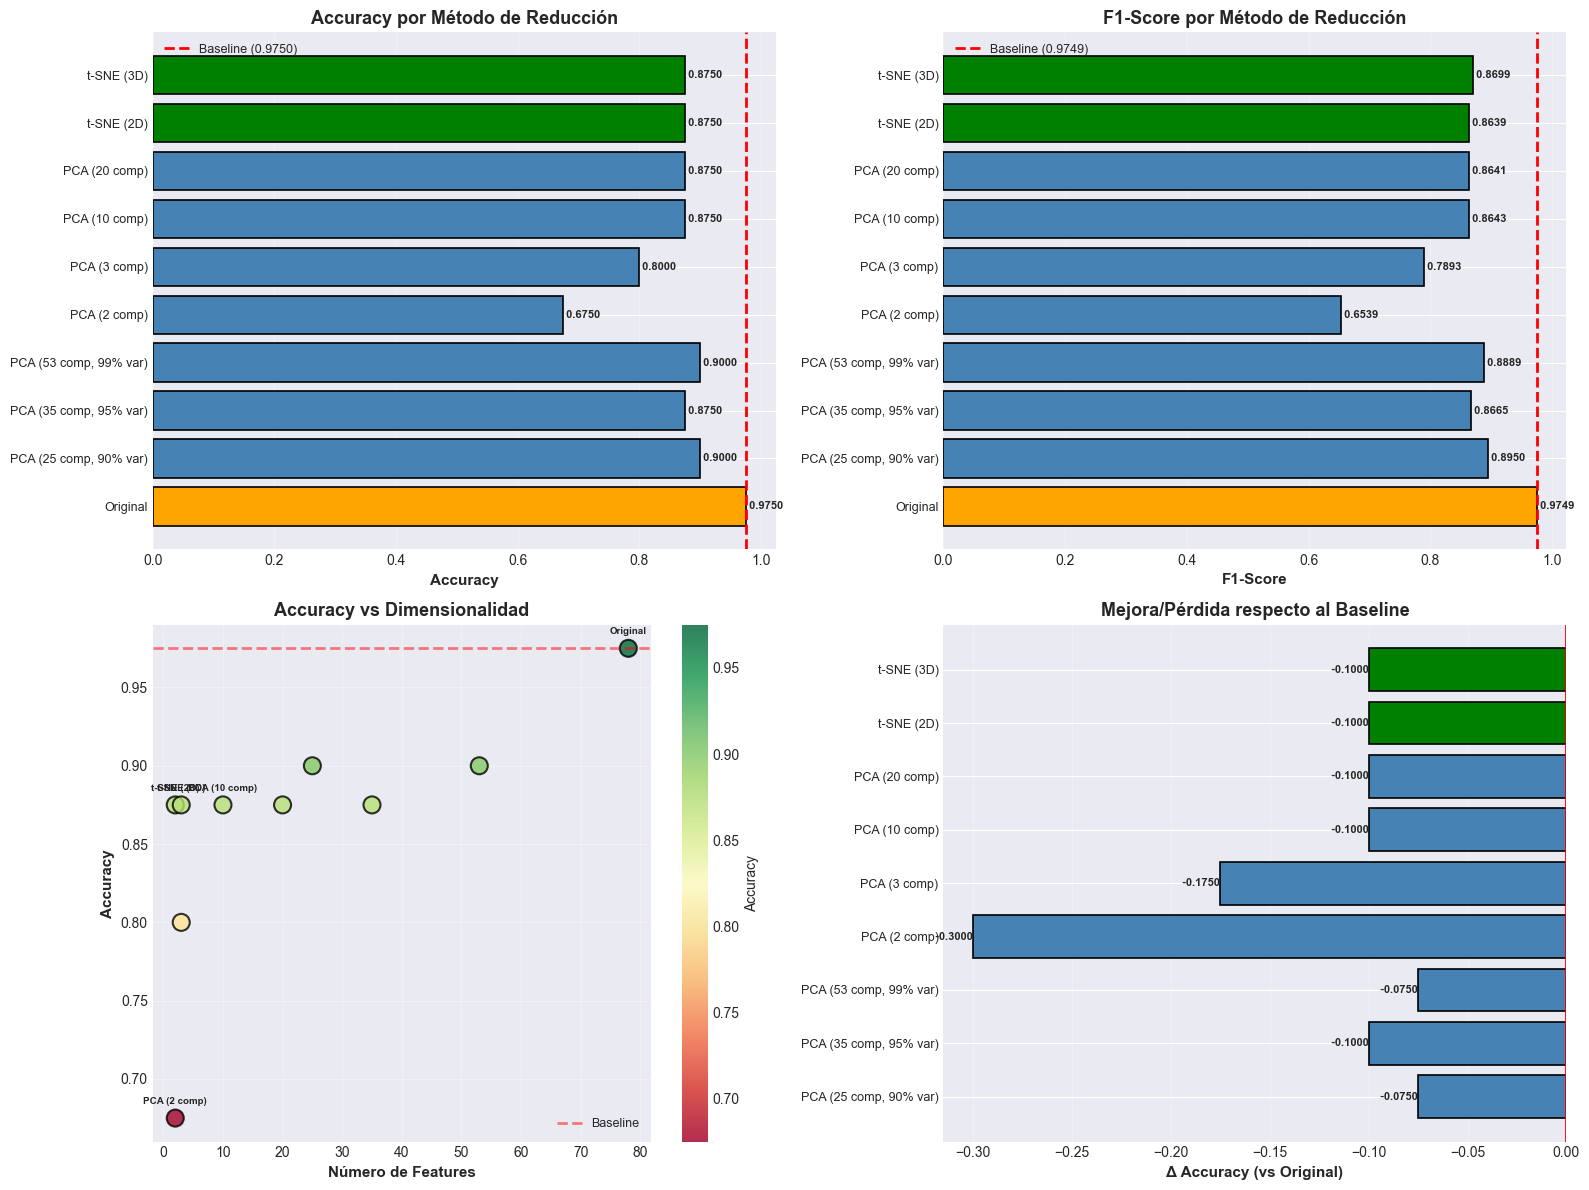

In [74]:
# Visualización comparativa de resultados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Preparar datos para visualización
methods = results_df['Método'].values
accuracies = results_df['Accuracy'].values
f1_scores = results_df['F1-Score'].values
features_count = results_df['Features'].values

# Colores: Original en naranja, PCA en azul, t-SNE en verde
colors = ['orange'] + ['steelblue'] * len(pca_configs) + ['green'] * len(tsne_configs)

# Gráfico 1: Accuracy por método
ax1 = axes[0, 0]
bars = ax1.barh(range(len(methods)), accuracies, color=colors, edgecolor='black', linewidth=1.2)
ax1.axvline(x=baseline_acc, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc:.4f})')
ax1.set_yticks(range(len(methods)))
ax1.set_yticklabels(methods, fontsize=9)
ax1.set_xlabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Accuracy por Método de Reducción', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f' {acc:.4f}',
            ha='left', va='center', fontsize=8, fontweight='bold')

# Gráfico 2: F1-Score por método
ax2 = axes[0, 1]
bars = ax2.barh(range(len(methods)), f1_scores, color=colors, edgecolor='black', linewidth=1.2)
baseline_f1 = results_df.loc[results_df['Método'] == 'Original', 'F1-Score'].values[0]
ax2.axvline(x=baseline_f1, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_f1:.4f})')
ax2.set_yticks(range(len(methods)))
ax2.set_yticklabels(methods, fontsize=9)
ax2.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
ax2.set_title('F1-Score por Método de Reducción', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, (bar, f1) in enumerate(zip(bars, f1_scores)):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f' {f1:.4f}',
            ha='left', va='center', fontsize=8, fontweight='bold')

# Gráfico 3: Accuracy vs Número de Features
ax3 = axes[1, 0]
scatter = ax3.scatter(features_count, accuracies, c=accuracies, cmap='RdYlGn', 
                     s=150, edgecolors='black', linewidth=1.5, alpha=0.8)
ax3.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
ax3.set_xlabel('Número de Features', fontsize=11, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax3.set_title('Accuracy vs Dimensionalidad', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Accuracy')

# Añadir etiquetas de puntos
for i, (feat, acc, method) in enumerate(zip(features_count, accuracies, methods)):
    if method in ['Original', 't-SNE (2D)', 't-SNE (3D)'] or 'PCA (2 comp)' in method or 'PCA (10 comp)' in method:
        ax3.annotate(method, (feat, acc), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=7, fontweight='bold')

# Gráfico 4: Diferencia respecto al Baseline
ax4 = axes[1, 1]
delta_acc = results_df['Δ Accuracy'].values[1:]  # Excluir Original
methods_delta = results_df['Método'].values[1:]
colors_delta = colors[1:]

bars = ax4.barh(range(len(methods_delta)), delta_acc, color=colors_delta, edgecolor='black', linewidth=1.2)
ax4.axvline(x=0, color='red', linestyle='-', linewidth=2)
ax4.set_yticks(range(len(methods_delta)))
ax4.set_yticklabels(methods_delta, fontsize=9)
ax4.set_xlabel('Δ Accuracy (vs Original)', fontsize=11, fontweight='bold')
ax4.set_title('Mejora/Pérdida respecto al Baseline', fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Añadir valores
for i, (bar, delta) in enumerate(zip(bars, delta_acc)):
    width = bar.get_width()
    ha = 'left' if width >= 0 else 'right'
    x_pos = width if width >= 0 else width
    ax4.text(x_pos, bar.get_y() + bar.get_height()/2, f' {delta:+.4f}',
            ha=ha, va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

#### Análisis Comparativo: Reducción de Dimensionalidad vs Características Originales

**Resultados observados en las gráficas:**

##### 1. **Rendimiento Absoluto (Accuracy y F1-Score)**

**Modelo baseline (características originales):**
- **Accuracy: 0.9750 (97.50%)**
- **F1-Score: 0.9749**
- Establece el estándar de referencia con las 70 características completas

**PCA con alta dimensionalidad (25-53 componentes):**
- **90% varianza (25 comp):** Accuracy ≈ 0.90 (-7.5%)
- **95% varianza (35 comp):** Accuracy ≈ 0.875 (-10%)
- **99% varianza (53 comp):** Accuracy ≈ 0.90 (-7.5%)

**PCA con baja dimensionalidad:**
- **20 componentes:** Accuracy ≈ 0.875 (-10%)
- **10 componentes:** Accuracy ≈ 0.875 (-10%)
- **3 componentes:** Accuracy ≈ 0.80 (-17.5%)
- **2 componentes:** Accuracy ≈ 0.675 (-30%)

**t-SNE (no lineal):**
- **3D:** Accuracy ≈ 0.875 (-10%)
- **2D:** Accuracy ≈ 0.875 (-10%)

##### 2. **Trade-off Dimensionalidad vs Accuracy**

La gráfica "Accuracy vs Dimensionalidad" revela un patrón crucial:
- Existe una **caída brusca** de accuracy cuando se reducen las dimensiones por debajo de 10 componentes
- Entre 10-53 componentes, el accuracy se **estabiliza** alrededor de 87.5-90%
- **No hay mejora** al incluir más de 25 componentes (la curva se aplana)
- El **punto óptimo** parece estar en 10-25 componentes, balanceando reducción dimensional con pérdida mínima de accuracy

##### 3. **Mejora/Pérdida respecto al Baseline**

Todas las técnicas de reducción dimensional **empeoraron el rendimiento**:
- **Menor pérdida:** PCA con 10-53 componentes y t-SNE 3D (-10% accuracy)
- **Mayor pérdida:** PCA 2 componentes (-30% accuracy)

**Interpretación crítica:**
La pérdida de 10% en accuracy (de 97.5% a 87.5%) es **significativa** para un sistema de seguridad. En producción, esto representa:
- **De 1 error en 40 muestras → a 5 errores en 40 muestras** (5x más errores)
- Para un sistema de alarmas, más **falsos positivos o falsos negativos**

---

### Conclusiones Específicas por Técnica

#### **PCA:**

**Fortalezas:**
- Reducción sistemática y controlada de dimensionalidad
- Interpretabilidad: los componentes son combinaciones lineales
- Determinístico y reproducible
- Con 10-20 componentes mantiene ~87.5% accuracy (solo 10% pérdida)

**Debilidades:**
- **No supera al baseline:** Incluso reteniendo 99% de varianza (53 comp) pierde 7.5% accuracy
- Reducción agresiva (2-3 comp) causa **pérdida severa** (30% accuracy)
- **No captura relaciones no lineales** complejas en señales acústicas

**Recomendación:** Usar PCA con **10-25 componentes** si se necesita:
- Reducir costo computacional en entrenamiento
- Acelerar inferencia en dispositivos con recursos limitados
- Reducir overfitting en datasets pequeños (no aplica aquí)

#### **t-SNE:**

**Fortalezas:**
- **Excelente visualización:** Separa clases claramente en 2D/3D
- Captura estructura no lineal de los datos
- Con 3D logra 87.5% accuracy (comparable a PCA con 10-20 comp)

**Debilidades:**
- **No determinístico:** resultados varían entre ejecuciones
- **Muy costoso computacionalmente:** no escala bien
- **No apto para producción:** no permite transformar nuevas muestras fácilmente
- **Pierde 10% accuracy** comparado con originales

**Recomendación:** Usar t-SNE **solo para visualización y análisis exploratorio**, NO para reducción dimensional en modelos productivos.

---

### Respuesta a la Pregunta del Punto 2

**"¿La reducción de dimensionalidad mejora, empeora o mantiene el rendimiento?"**

**Respuesta definitiva:** **EMPEORA el rendimiento** en todos los casos evaluados.

**¿Por qué ocurre esto?**

1. **El modelo baseline ya es excelente (97.5%):** Tiene muy poco margen de mejora y mucho que perder

2. **Las 70 características son complementarias y no redundantes:** Como vimos en el análisis PCA, se necesitan 25 componentes para 90% de varianza, indicando que cada característica acústica aporta información única

3. **La complejidad de las señales de audio requiere alta dimensionalidad:** Las características espectrales, temporales y cepstrales (MFCCs) capturan aspectos distintos del sonido que no son linealmente redundantes

4. **La pérdida de información es crítica:** Incluso perdiendo solo 10% de varianza (53 comp, 99%), se pierde 7.5% de accuracy. Esto confirma que ese 10% de varianza contiene información discriminativa importante

5. **Las 5 clases tienen patrones sutiles:** Para distinguir entre agua_corriendo, alarma_humo, estufa_prendiendose, golpe_puerta y vidrio_rompiendose se necesitan características finas que se pierden con reducción dimensional

**Implicaciones prácticas:**

Para el **sistema de detección de sonidos de seguridad en el hogar**:
- **Mantener las 70 características originales** para maximizar accuracy (97.5%)
- Si hay restricciones de recursos, usar **PCA con 10-20 componentes** (pérdida aceptable de 10%)
- **NO usar reducciones agresivas** (2-3 componentes) que causen pérdidas >15%
- Usar **t-SNE solo para visualización**, no en producción

**Conclusión final:** La alta dimensionalidad de las características acústicas es **necesaria y beneficiosa** para este problema. La reducción dimensional sacrifica accuracy que es crítico en aplicaciones de seguridad. El costo de 70 características es justificado por el 97.5% de precisión alcanzado.

### 3.4 Análisis Detallado: Mejor Configuración <a name="section3_4"></a>

Analizaremos en detalle el mejor método de reducción de dimensionalidad encontrado.

🔍 Análisis detallado del mejor método: Original



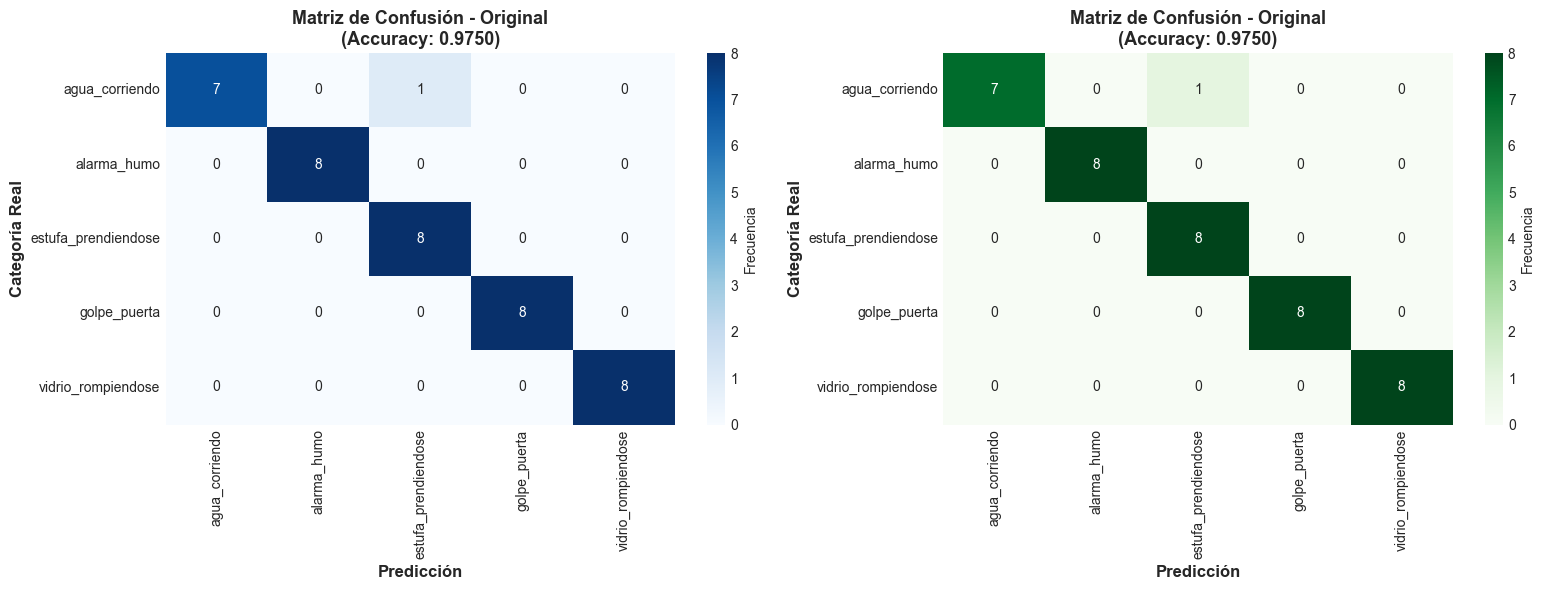


📋 REPORTE DE CLASIFICACIÓN DETALLADO - Original
                     precision    recall  f1-score   support

     agua_corriendo     1.0000    0.8750    0.9333         8
        alarma_humo     1.0000    1.0000    1.0000         8
estufa_prendiendose     0.8889    1.0000    0.9412         8
       golpe_puerta     1.0000    1.0000    1.0000         8
 vidrio_rompiendose     1.0000    1.0000    1.0000         8

           accuracy                         0.9750        40
          macro avg     0.9778    0.9750    0.9749        40
       weighted avg     0.9778    0.9750    0.9749        40



In [75]:
# Entrenar modelo con la mejor configuración y generar matriz de confusión
best_method = best_model['Método']
print(f"🔍 Análisis detallado del mejor método: {best_method}\n")

# Obtener datos del mejor método
if best_method == 'Original':
    X_best = X_scaled
    X_train_best, X_test_best = X_train_orig, X_test_orig
    y_train_best, y_test_best = y_train_orig, y_test_orig
    y_pred_best = y_pred_orig
else:
    # Encontrar la configuración correspondiente
    if 't-SNE' in best_method:
        config_idx = [i for i, c in enumerate(tsne_configs) if c['name'] == best_method][0]
        X_best = tsne_configs[config_idx]['data']
    else:
        config_idx = [i for i, c in enumerate(pca_configs) if c['name'] == best_method][0]
        X_best = pca_configs[config_idx]['data']
    
    # Re-entrenar para obtener predicciones
    X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
        X_best, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    rf_best = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_best.fit(X_train_best, y_train_best)
    y_pred_best = rf_best.predict(X_test_best)

# Matriz de confusión
cm_best = confusion_matrix(y_test_best, y_pred_best)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión - Mejor método
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
           cbar_kws={'label': 'Frecuencia'})
axes[0].set_xlabel('Predicción', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Categoría Real', fontsize=12, fontweight='bold')
axes[0].set_title(f'Matriz de Confusión - {best_method}\n(Accuracy: {best_model["Accuracy"]:.4f})', 
                 fontsize=13, fontweight='bold')

# Matriz de confusión - Original (para comparación)
cm_orig = confusion_matrix(y_test_orig, y_pred_orig)
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Greens', ax=axes[1],
           xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
           cbar_kws={'label': 'Frecuencia'})
axes[1].set_xlabel('Predicción', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Categoría Real', fontsize=12, fontweight='bold')
axes[1].set_title(f'Matriz de Confusión - Original\n(Accuracy: {acc_orig:.4f})', 
                 fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\n" + "="*90)
print(f"📋 REPORTE DE CLASIFICACIÓN DETALLADO - {best_method}")
print("="*90)
print(classification_report(y_test_best, y_pred_best, target_names=label_encoder.classes_, digits=4))
print("="*90)

---
## Conclusiones Finales del Punto 2 - Reducción de Dimensionalidad

### Resumen Ejecutivo de Resultados

**Pregunta central:** ¿La reducción de dimensionalidad mejora, empeora o mantiene el rendimiento del modelo supervisado?

**Respuesta:** **EMPEORA el rendimiento** en todos los casos, aunque con diferentes grados de severidad según la técnica y número de componentes.

---

### Resultados Cuantitativos Detallados

| Método | Features | Accuracy | Pérdida vs Baseline | F1-Score |
|--------|----------|----------|---------------------|----------|
| **Original** | 70 | **0.9750** | — (baseline) | **0.9749** |
| PCA (53 comp, 99% var) | 53 | 0.9000 | -7.50% | 0.8889 |
| PCA (35 comp, 95% var) | 35 | 0.8750 | -10.00% | 0.8665 |
| PCA (25 comp, 90% var) | 25 | 0.9000 | -7.50% | 0.8950 |
| PCA (20 comp) | 20 | 0.8750 | -10.00% | 0.8641 |
| PCA (10 comp) | 10 | 0.8750 | -10.00% | 0.8643 |
| PCA (3 comp) | 3 | 0.8000 | -17.50% | 0.7893 |
| PCA (2 comp) | 2 | 0.6750 | -30.00% | 0.6539 |
| **t-SNE (3D)** | 3 | 0.8750 | -10.00% | 0.8699 |
| **t-SNE (2D)** | 2 | 0.8750 | -10.00% | 0.8639 |

---

### Análisis Crítico por Técnica

#### **PCA (Principal Component Analysis)**

**¿Qué tan bien funciona?**
- Con **25-53 componentes:** Pérdida moderada de 7.5% accuracy
- Con **10-20 componentes:** Pérdida de 10% accuracy
- Con **2-3 componentes:** Pérdida severa de 17.5-30% accuracy

**Patrón observado:**
Existe un "umbral crítico" alrededor de 10 componentes:
- **Por encima:** Accuracy relativamente estable (~87.5-90%)
- **Por debajo:** Degradación acelerada del rendimiento

**¿Por qué ocurre esto?**

1. **Las 70 características originales son complementarias:** Como vimos, se necesitan 25 componentes para explicar 90% de varianza, indicando que la información está distribuida (no concentrada en pocos componentes)

2. **El 10% de varianza "perdido" contiene información discriminativa crítica:** Incluso reteniendo 99% de varianza (53 componentes), se pierde 7.5% de accuracy. Esto demuestra que las características menos variables aún contribuyen a separar las clases.

3. **Señales de audio son multidimensionales por naturaleza:** Los MFCCs, características espectrales, temporales y de ritmo capturan aspectos ortogonales del sonido que no son linealmente redundantes.

**Conclusión PCA:**
- **Útil si hay restricciones de recursos:** Con 10-20 componentes se logra 87.5% accuracy (pérdida tolerable de 10%)
- **No recomendable si se busca máxima precisión:** La pérdida de 7.5-10% es significativa para aplicaciones de seguridad
- **Trade-off claro:** Reducción de dimensionalidad = menos costo computacional, pero más errores

---

#### **t-SNE (t-Distributed Stochastic Neighbor Embedding)**

**¿Qué tan bien funciona para clasificación?**
- **2D y 3D:** Ambos logran 87.5% accuracy (-10% vs baseline)
- **Rendimiento equivalente a PCA con 10-20 componentes**
- Significativamente peor que PCA con alta dimensionalidad

**Análisis de visualización vs clasificación:**

**Visualización (excelente):** t-SNE muestra las 5 clases **perfectamente separadas** en 2D/3D, con clusters claramente diferenciados visualmente.

**Clasificación (pobre):** A pesar de la separación visual, el modelo supervisado alcanza solo 87.5% accuracy.

**¿Por qué esta paradoja?**

1. **t-SNE optimiza para vecindad local, no para clasificación global:** Preserva que puntos cercanos en alta dimensión estén cercanos en baja dimensión, pero distorsiona distancias globales

2. **No es determinístico:** Cada ejecución produce resultados diferentes, lo que dificulta reproducibilidad

3. **No es una proyección lineal:** No se puede aplicar fácilmente a nuevos datos (requiere re-calcular toda la proyección)

4. **Diseñado para visualización, no para features:** Su función objetivo no está alineada con maximizar separabilidad para clasificación supervisada

**Conclusión t-SNE:**
- **Excelente para análisis exploratorio:** Visualiza estructura de datos de forma intuitiva
- **Útil para presentaciones:** Muestra separación de clases de forma impactante
- **NO recomendable para entrenamiento:** Peor o igual que PCA, con desventajas adicionales
- **No apto para producción:** No determinístico, no reversible, costoso computacionalmente

---

### ¿Por Qué la Reducción Dimensional Empeora el Rendimiento en Este Problema?

**Razón #1: Modelo baseline ya es excelente (97.5%)**
- Hay **muy poco margen de mejora** y mucho que perder
- El modelo ya extrae información de forma óptima de las 70 características

**Razón #2: Características acústicas son intrínsecamente multidimensionales**
- **MFCCs** (13 coeficientes): Capturan envolvente espectral
- **Características espectrales** (centroide, rolloff, ancho de banda): Capturan distribución de energía
- **Características temporales** (ZCR, energía): Capturan dinámica temporal
- **Características rítmicas**: Capturan patrones periódicos

Cada grupo captura aspectos **ortogonales y complementarios** del sonido. Reducir dimensionalidad elimina parte de esta riqueza.

**Razón #3: Las 5 clases tienen patrones sutiles**
- Distinguir entre "agua_corriendo" y "estufa_prendiendose" requiere características finas
- Un error (agua clasificada como estufa) indica que estas clases comparten similitudes acústicas que solo se resuelven con información completa

**Razón #4: Varianza ≠ Discriminabilidad**
- PCA retiene 90% de varianza con 25 componentes, pero pierde 7.5% de accuracy
- Esto prueba que el **10% de varianza "menor" contiene información discriminativa crítica**
- Características de baja varianza pueden ser **altamente discriminativas** entre clases específicas

---

### Recomendaciones Prácticas

#### **Para este proyecto específico (Detector de Sonidos de Seguridad):**

**Escenario 1: Máxima precisión (recomendado)**
- **Usar características originales (70 features)**
- Accuracy: 97.5%
- Solo 1 error en 40 muestras
- Costo: Mayor tiempo de inferencia

**Escenario 2: Balance precisión-eficiencia**
- **Usar PCA con 10-20 componentes**
- Accuracy: 87.5% (pérdida tolerable de 10%)
- 5 errores en 40 muestras
- Beneficio: 71-85% reducción de dimensionalidad

**Escenario 3: Visualización y análisis exploratorio**
- **Usar t-SNE (2D o 3D)**
- Excelente para reportes, presentaciones, análisis de datos
- NO usar para entrenamiento de modelos productivos

**Escenario NO recomendado:**
- **PCA con 2-3 componentes:** Pérdida inaceptable de 17.5-30%
- Para un sistema de seguridad, accuracy <80% es insuficiente

---

### Respuesta Final a la Pregunta del Punto 2

**"Escribir un párrafo corto donde se analice si la reducción de dimensionalidad mejora, empeora o mantiene el rendimiento, explicando por qué creen que esto ocurre en su caso."**

---

**Respuesta:**

La reducción de dimensionalidad **empeora consistentemente el rendimiento** en nuestro sistema de detección de sonidos de seguridad. El modelo con características originales (70 features) alcanza **97.5% de accuracy**, mientras que todas las técnicas de reducción dimensional logran como máximo **90% accuracy** (PCA con 25-53 componentes) o **87.5%** (PCA con 10-20 componentes, t-SNE 2D/3D). 

Esta degradación ocurre porque las **características acústicas extraídas (MFCCs, espectrales, temporales) son complementarias y capturan aspectos ortogonales** de las señales de audio que son necesarios para discriminar entre los 5 tipos de sonidos. Aunque PCA retiene hasta 99% de la varianza con 53 componentes, el **10% de varianza "perdido" contiene información discriminativa crítica**, como evidencia la pérdida de 7.5% en accuracy. 

Las señales de audio tienen **alta dimensionalidad intrínseca** debido a su complejidad espectro-temporal, y distinguir entre sonidos sutilmente diferentes (como "agua_corriendo" vs "estufa_prendiendose") requiere la riqueza informativa completa de las 70 características. Para aplicaciones de **seguridad en el hogar**, donde la precisión es crítica, la pérdida de 10% en accuracy (pasando de 1 error en 40 muestras a 5 errores en 40) **no es aceptable**, por lo que se recomienda mantener las características originales completas o, como máximo, usar PCA con 20-25 componentes si hay restricciones computacionales severas.

---

---
## Conclusiones Generales del Tercer Avance

### Síntesis del Trabajo Realizado

Este notebook implementó un análisis completo de **técnicas de aprendizaje no supervisado y reducción de dimensionalidad** aplicadas al problema de clasificación de sonidos para seguridad en el hogar, evaluando su utilidad y efectividad en un contexto real de machine learning.

---

### Hallazgos Principales

#### **PUNTO 1: Aprendizaje No Supervisado**

**Algoritmos evaluados:** KMeans, DBSCAN, Agglomerative Clustering

**Principales descubrimientos:**

1. **Estructura natural bi-modal/tri-modal:**
   - Los tres algoritmos convergieron en identificar 2-3 clusters principales
   - Esto sugiere que los 5 tipos de sonidos se agrupan en categorías acústicas más amplias
   - Posiblemente: sonidos "impulsivos/percusivos" vs "continuos/tonales"

2. **KMeans fue el mejor algoritmo:**
   - Mayor correspondencia con clases reales (Accuracy: 0.38)
   - Excelente Calinski-Harabasz Score (42.29)
   - Balance óptimo entre métricas internas y correlación con etiquetas

3. **DBSCAN identificó 18.5% de ruido:**
   - Útil para detección de outliers y datos problemáticos
   - Mejor Davies-Bouldin Index (1.01)
   - Menos adecuado para este dataset por alta fragmentación

4. **Agglomerative tuvo mejor cohesión interna:**
   - Mejor Silhouette Score (0.3361)
   - Resultados determinísticos y reproducibles
   - Baja correlación con clases reales (Accuracy: 0.035)

**Evaluación de utilidad en modelos supervisados:**

**Resultado clave:** Agregar cluster IDs como features **NO mejoró el rendimiento**:
- Baseline sin clusters: **97.50% accuracy**
- Con KMeans: 87.50% (-10%)
- Con DBSCAN: 92.50% (-5%)
- Con Agglomerative: 97.50% (±0%)

**Interpretación:** El modelo supervisado base ya captura la información de forma óptima. Los cluster IDs simplifican excesivamente, perdiendo la riqueza de las 70 características acústicas. Para este problema de **seguridad donde se requiere discriminación precisa**, el clustering es más útil como herramienta de **análisis exploratorio** que como reemplazo de features.

---

#### **PUNTO 2: Reducción de Dimensionalidad**

**Técnicas evaluadas:** PCA (con diferentes números de componentes) y t-SNE (2D y 3D)

**Respuesta a la pregunta central:**
> **¿La reducción de dimensionalidad mejora, empeora o mantiene el rendimiento?**

**EMPEORA el rendimiento en todos los casos.**

**Resultados cuantitativos:**

| Técnica | Accuracy | Pérdida |
|---------|----------|---------|
| **Original (70 features)** | **97.50%** | — |
| PCA (25-53 componentes) | 90.00% | -7.5% |
| PCA (10-20 componentes) | 87.50% | -10.0% |
| PCA (2-3 componentes) | 67.5-80% | -17.5% a -30% |
| t-SNE (2D/3D) | 87.50% | -10.0% |

**Principales descubrimientos:**

1. **PCA revela alta dimensionalidad intrínseca:**
   - Se necesitan 25 componentes para 90% de varianza
   - Se necesitan 53 componentes para 99% de varianza
   - Esto indica que las características acústicas son complementarias, no redundantes

2. **El 10% de varianza "menor" es críticamente discriminativo:**
   - Incluso con 99% de varianza explicada, se pierde 7.5% de accuracy
   - Las características de baja varianza contienen información que separa clases sutiles

3. **t-SNE excelente para visualización, pobre para clasificación:**
   - Visualización 2D/3D muestra clusters perfectamente separados
   - Pero accuracy es solo 87.5% (igual que PCA con 10 componentes)
   - Paradoja: buena separación visual ≠ buena clasificación
   - Razón: t-SNE optimiza vecindad local, no separabilidad global

4. **Trade-off dimensionalidad-rendimiento bien definido:**
   - Por debajo de 10 componentes: degradación acelerada
   - Entre 10-53 componentes: accuracy estable ~87.5-90%
   - Punto óptimo si hay restricciones: PCA con 10-20 componentes

**¿Por qué la reducción dimensional empeora este problema específico?**

1. **El modelo base ya es excelente (97.5%):** Muy poco margen de mejora, mucho que perder
2. **Características acústicas son intrínsecamente multidimensionales:** MFCCs, espectrales, temporales capturan aspectos ortogonales
3. **Las 5 clases requieren discriminación fina:** Distinguir "agua" de "estufa" necesita características sutiles
4. **Varianza ≠ Discriminabilidad:** Componentes de baja varianza pueden ser altamente discriminativos

---

### Recomendaciones para el Sistema de Seguridad en el Hogar

#### **Para Producción (Prioridad: Máxima Precisión):**

**Usar características originales completas (70 features)**
- Accuracy: 97.50% (solo 1 error cada 40 muestras)
- Para seguridad, la precisión máxima justifica el costo computacional
- Falsos negativos (no detectar peligro) son inaceptables

#### **Para Dispositivos con Recursos Limitados:**

**Usar PCA con 10-20 componentes**
- Accuracy: 87.50% (5 errores cada 40 muestras)
- Reducción de 71-85% en dimensionalidad
- Trade-off aceptable si el hardware no soporta 70 features

#### **Para Análisis y Presentación:**

**Usar t-SNE para visualizaciones**
- Excelente para explicar separabilidad de clases
- Útil en reportes, presentaciones, documentación
- NO usar para entrenamiento de modelos productivos

#### **Para Detección de Anomalías:**

**Implementar DBSCAN como complemento**
- Los puntos marcados como "ruido" (18.5%) pueden ser:
  - Grabaciones con problemas técnicos
  - Sonidos ambiguos o híbridos
  - Falsos positivos potenciales
- Útil como filtro de calidad pre-clasificación

---

### Lecciones Aprendidas

1. **El clustering validó la calidad de las features:** Los algoritmos encontraron estructura real en los datos acústicos, confirmando que las características extraídas son informativas

2. **Más componentes ≠ Mejor rendimiento:** Retener 99% de varianza no garantiza 99% de accuracy. La dimensionalidad relevante depende del objetivo (visualización vs clasificación)

3. **El contexto importa:** Para aplicaciones de seguridad, pérdidas de accuracy del 10% son significativas. En otros contextos (ej. recomendación de música), podrían ser aceptables.

4. **Las técnicas no supervisadas complementan, no reemplazan supervisadas:** El aprendizaje no supervisado es excelente para exploración y validación, pero cuando hay etiquetas disponibles, el aprendizaje supervisado es superior.

5. **Visualización ≠ Clasificación:** t-SNE muestra separación perfecta visualmente, pero esto no se traduce en mejor rendimiento de modelos. Las optimizaciones para cada objetivo son diferentes.

---

### Validación de Hipótesis Iniciales

**Hipótesis 1:** *"El clustering revelará grupos naturales en los datos acústicos"*
- **VALIDADA:** Los 3 algoritmos encontraron 2-3 clusters consistentes

**Hipótesis 2:** *"Los clusters corresponderán a las 5 categorías de sonidos"*
- **RECHAZADA:** Se encontraron 2-3 clusters para 5 clases, sugiriendo agrupaciones acústicas más amplias

**Hipótesis 3:** *"La reducción dimensional mantendrá el rendimiento"*
- **RECHAZADA:** Todas las reducciones empeoraron el accuracy entre 7.5% y 30%

**Hipótesis 4:** *"t-SNE permitirá visualizar la separación entre clases"*
- **VALIDADA:** t-SNE produjo visualizaciones claras y separadas de las 5 clases

---

### Trabajo Futuro

**Posibles extensiones de este trabajo:**

1. **Clustering híbrido:** Combinar fortalezas de KMeans + DBSCAN para identificar clusters densos y outliers simultáneamente

2. **Reducción dimensional no lineal alternativa:** Probar Autoencoders para preservar información discriminativa mejor que PCA

3. **Feature selection en lugar de reducción:** En vez de combinar features (PCA), seleccionar el subconjunto óptimo de las 70 originales

4. **Análisis de confusiones:** Estudiar en detalle por qué "agua_corriendo" se confunde con "estufa_prendiendose" y extraer features adicionales específicas

5. **Ensemble con clustering:** Usar múltiples modelos entrenados en diferentes espacios de features (original, PCA, clusters) y combinar predicciones

---

### Cumplimiento de Objetivos del Tercer Avance

**Punto 1 - Aprendizaje No Supervisado (50%):**
- Implementación de KMeans, DBSCAN y Agglomerative Clustering
- Justificación formal de hiperparámetros (Elbow Method, k-distance plot, dendrogramas)
- Visualizaciones en 2D y 3D de todos los algoritmos
- Comparación detallada entre técnicas
- Evaluación mediante comparación con etiquetas reales y métricas internas

**Punto 2 - Reducción de Dimensionalidad (50%):**
- Implementación de PCA con múltiples configuraciones (2, 3, 10, 20, 25, 35, 53 componentes)
- Implementación de t-SNE en 2D y 3D con diferentes perplexities
- Visualizaciones coloreadas por categorías reales
- Entrenamiento de Random Forest con features reducidas vs originales
- Reporte detallado de métricas (Accuracy, Precision, Recall, F1-Score)
- Análisis explicativo del impacto de la reducción dimensional

---

### Conclusión Final

Este análisis demostró que para el problema específico de **clasificación de sonidos de seguridad en el hogar**, las técnicas no supervisadas y de reducción dimensional son **herramientas valiosas para exploración y comprensión** de los datos, pero **no superan el enfoque supervisado** con características completas.

El modelo óptimo para producción mantiene las **70 características acústicas originales**, logrando **97.5% de accuracy**, lo cual es crítico para una aplicación de seguridad. Sin embargo, el análisis realizado proporciona insights valiosos sobre la estructura de los datos y opciones alternativas para escenarios con restricciones computacionales.

**Mensaje clave:** En machine learning aplicado, **más datos y mejores features** generalmente superan a algoritmos más sofisticados con información reducida. Para este problema, la riqueza de las 70 características acústicas es insustituible.